In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import shutil
from pathlib import Path

import aps_ai
import aps_ai.beamline34IDC.optimization.movers as movers
import IPython
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from aps_ai.beamline34IDC.optimization import common as opt_common
from aps_ai.beamline34IDC.optimization import configs, display_utils, movers
from aps_ai.beamline34IDC.optimization.display_utils import LivePlotCallback
from aps_ai.beamline34IDC.optimization.scipy_nelder_mead import ScipyOptimizer
from aps_ai.beamline34IDC.optimization.skopt_gp import SkoptDiscreteGPOptimizer, SkoptGaussianProcessOptimizer
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement
from aps_ai.common.util import clean_up
from aps_ai.common.util.shadow.common import (
    EmptyBeamException,
    PreProcessorFiles,
    get_shadow_beam_spatial_distribution,
    load_shadow_beam,
    plot_shadow_beam_spatial_distribution,
)
from skopt.callbacks import DeadlineStopper, DeltaXStopper, DeltaYStopper
from tqdm import tqdm

In [5]:
%matplotlib inline

In [28]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

16946


In [29]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test


In [30]:
np.__path__

['/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy']

In [31]:
aps_ai.__path__[0]

'/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai'

In [37]:
root_dir = Path(aps_ai.__path__[0]).parents[0]
base_dir = root_dir / 'work_directory'
orig_work_dir = base_dir /'34-ID'
temp_work_dir = base_dir / f'tmp_work_dir_34-ID-{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [39]:
base_dir, temp_work_dir

(PosixPath('/Users/skandel/code/oasys/AI-ML_Control_System/work_directory'),
 PosixPath('/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946'))

In [40]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [41]:
os.chdir(temp_work_dir)

In [42]:
input_beam_path = "primary_optics_system_beam.dat"

In [52]:
move_motors_ranges = {'hkb_1': [-30, 30], 
                      'vkb_1': [-30, 30],
                      'hkb_2': [-30, 30],
                      'vkb_2': [-30, 30],
                      'hkb_3': [-0.04, 0.04],
                      'vkb_3': [-0.04, 0.04],
                      'hkb_4': [-30, 30], 
                      'vkb_4': [-30, 30]}

In [44]:
save_figs = False

if save_figs:
    motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
    fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
    if not os.path.isdir(fig_save_path):
        os.mkdir(fig_save_path)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

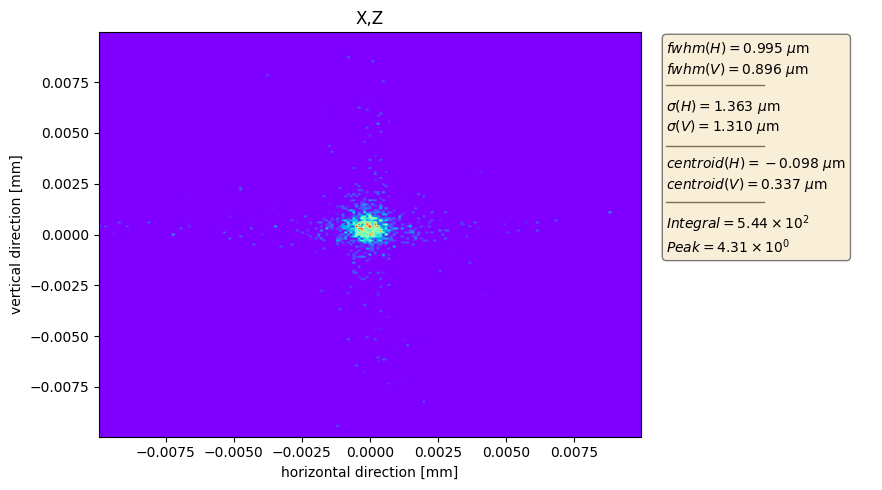

In [45]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=2)

plot_shadow_beam_spatial_distribution(focusing_system.get_photon_beam(),  nbins=201, xrange=[-0.01, 0.01], yrange=[-0.01, 0.01])

In [46]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[215.5 144.  112.5 231.5   3.    3.    0.    0. ]


In [91]:
class OptunaOptimizer(opt_common.OptimizationCommon):
    """"""
    opt_platform = 'optuna'

    
    def set_optimizer_options(self, motor_ranges: list=None, 
                              base_sampler: optuna.samplers.BaseSampler = None, 
                              directions: str = None, 
                              integral_threshold: float = 1e2,
                              raise_prune_exception: bool = True,
                              **extra_options):
        
        self.motor_ranges = self._get_guess_ranges(motor_ranges)
        
        if base_sampler is None:
            #if self.multi_objective_optimization:
            #    base_sampler = optuna.samplers.MOTPESampler()
            #else:
            base_sampler = optuna.samplers.TPESampler()
        self._base_sampler = base_sampler
        self._raise_prune_exception = raise_prune_exception
        
        if directions is None:
            directions = ['minimize'] * len(self._loss_function_list)
        elif len(directions) != len(self._loss_function_list):
            raise ValueError
        self._directions = directions
        
        self.study = optuna.create_study(sampler=self._base_sampler, directions=self._directions)
        self.study.enqueue_trial({mt: 0. for mt in self.motor_types})
        
        loss_fn_obj = self.TrialInstanceLossFunction(self, verbose=False)
        self._loss_fn_this = loss_fn_obj.loss
        self.integral_threshold = integral_threshold
        
        self.best_params = {k: 0. for k in self.motor_types}
    
    def _objective(self, trial):
        current_params = []
        for mot, r in zip(self.motor_types, self.motor_ranges):
            resolution = configs.DEFAULT_MOTOR_RESOLUTIONS[mot]
            #print(mot, 'Min, max, resolution', r[0], r[1], resolution)
            current_params.append(trial.suggest_float(mot, r[0], r[1], step=resolution))
        loss = self._loss_fn_this(current_params)
        if self.multi_objective_optimization:
            if np.nan in loss and self._raise_prune_exception:
                raise optuna.TrialPruned
            loss[np.isnan(loss)] = 1e4
            
            if self.integral_threshold is not None:
                if self.beam_state.hist.data_2D.sum() < self.integral_threshold:
                    if self._raise_prune_exception:
                        raise optuna.TrialPruned
                    else:
                        return [1e4] * len(self._loss_function_list)
                    
            
            for k in ['sigma', 'fwhm']:
                if k in self.loss_parameters:
                    width_idx = self.loss_parameters.index(k)
                    if loss[width_idx] == 0: loss[width_idx] = 1e4
            loss = list(loss)
        

        rads = (self.beam_state.hist.hh**2 + self.beam_state.hist.vv**2)**0.5
        weighted_sum_ints = np.sum(self.beam_state.hist.data_2D * rads)
        trial.set_user_attr("wsum", weighted_sum_ints)
            
        return loss
    
    def trials(self, n_trials: int, trial_motor_types: list = None):
        if trial_motor_types is None:
            self.study.optimize(self._objective, n_trials)
            
        else:
            
            fixed_params = {k: self.best_params[k] for k in self.best_params if k not in trial_motor_types}
            partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
            
            self.study.sampler = partial_sampler
            self.study.optimize(self._objective, n_trials=n_trials)
            
            self.study.sampler = self._base_sampler
        
        self.best_params.update(self.study.best_trials[0].params)
    
    def _optimize(self):
        pass

    #def set_optimizer_options(self):
    #    pass
    

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

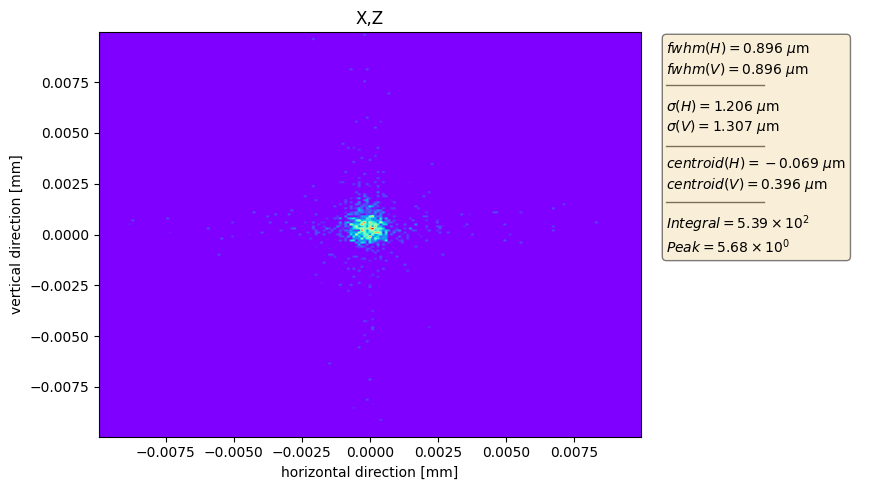

In [55]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=2)
plot_shadow_beam_spatial_distribution(focusing_system.get_photon_beam(random_seed=DEFAULT_RANDOM_SEED), nbins=201, xrange=[-0.01, 0.01], yrange=[-0.01, 0.01])

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

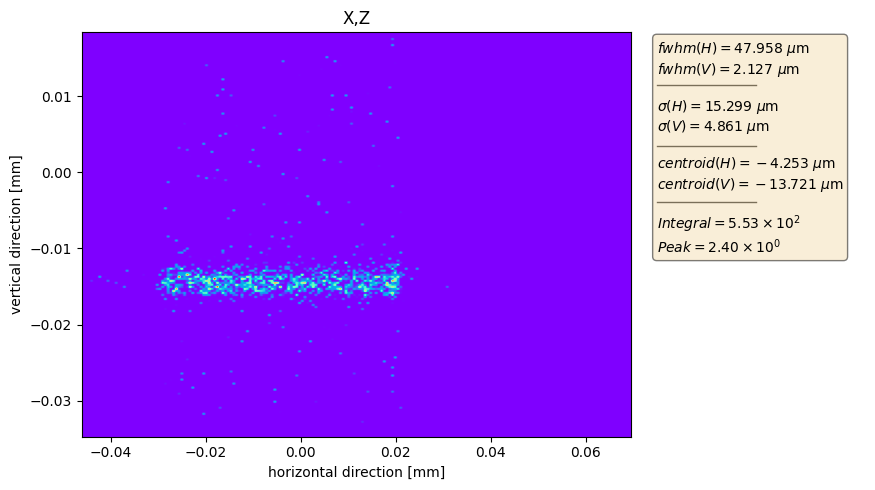

In [56]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=[-0.02, 0.02],
    yrange=[-0.02, 0.02],
    integral_threshold=50,
    nbins=128,
    random_seed=DEFAULT_RANDOM_SEED,
    verbose=True
)
# plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
# plt.colorbar()
# plt.show()
plot_shadow_beam_spatial_distribution(beam)

In [92]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

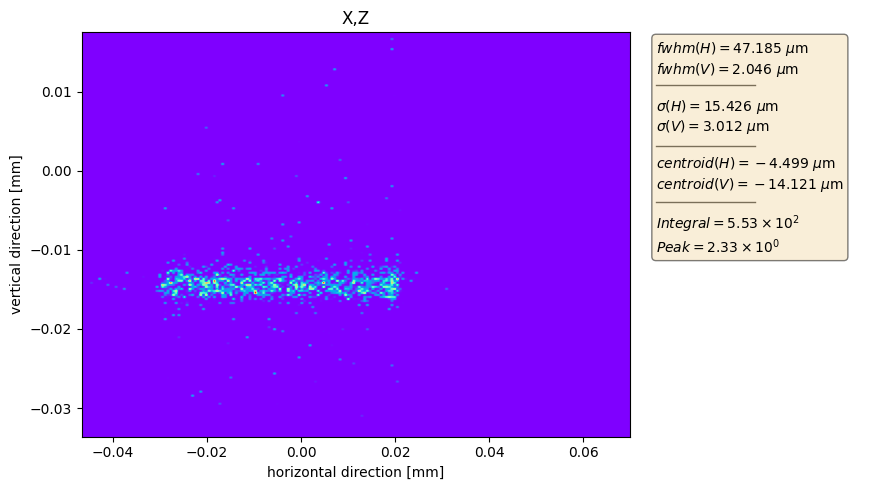

In [93]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [94]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.02, 0.02],
                            camera_yrange=[-0.02, 0.02],
                            camera_nbins=201)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [95]:
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()), integral_threshold=300)

[I 2022-10-12 23:37:23,486] A new study created in memory with name: no-name-26b000b1-baa7-4658-902e-93bb73ce0a98


In [96]:
centroid_ground, sigma_ground = opt_trial._loss_fn_this(-np.array(initial_movement))
centroid_ground, sigma_ground

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

(0.000522058907551784, 0.002856676777698409)

In [97]:
opt_trial._loss_fn_this(np.array(initial_movement))

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

array([nan, nan])

In [98]:
opt_trial.trials(100, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_29909/3298524706.py:78: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:37:30,905] Trial 0 finished with values: [0.01398778999862773, 0.012879729518888989] and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. 
[I 2022-10-12 23:37:32,328] Trial 1 finished with values: [0.014605628819255855, 0.012022302358253408] and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.001887902047863911, 'hkb_4': -2.3999999999999986, 'vkb_4': -1.1999999999999993}. 
[I 2022-10-12 23:37:33,714] Trial 2 pruned. 
[I 2022-10-12 23:37:34,981] Trial 3 pruned. 
[I 2022-10-12 23:37:37,411] Trial 4 pruned. 
[I 2022-10-12 23:37:39,422] Trial 5 finished with values: [0.002613381765247105, 0.003234068454673552] and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.026322511575784517, 'hkb_4': 14.200000000000003, 'vkb_4': 0.0}. 
[I 2022-10-12 23:37:40,818] Trial 6 finished w

In [99]:
opt_trial.study.best_trials

[FrozenTrial(number=5, values=[0.002613381765247105, 0.003234068454673552], datetime_start=datetime.datetime(2022, 10, 12, 23, 37, 37, 412227), datetime_complete=datetime.datetime(2022, 10, 12, 23, 37, 39, 422593), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.026322511575784517, 'hkb_4': 14.200000000000003, 'vkb_4': 0.0}, distributions={'hkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_29909/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


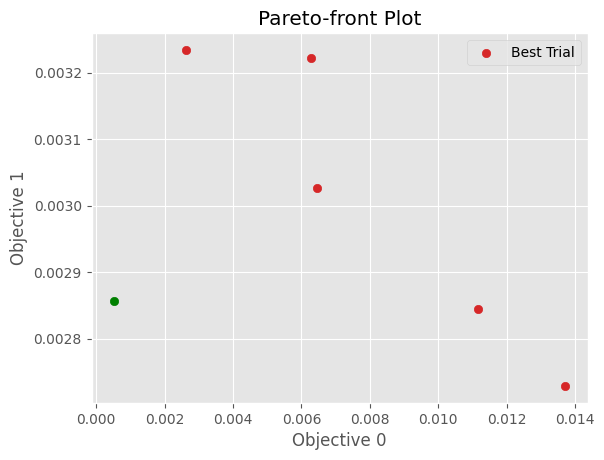

In [100]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [101]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-11.68112455170668
-10.358888212463786
-10.810373521297704
-10.842448880303003
-10.193838765881207


[0.002613381765247105, 0.003234068454673552]


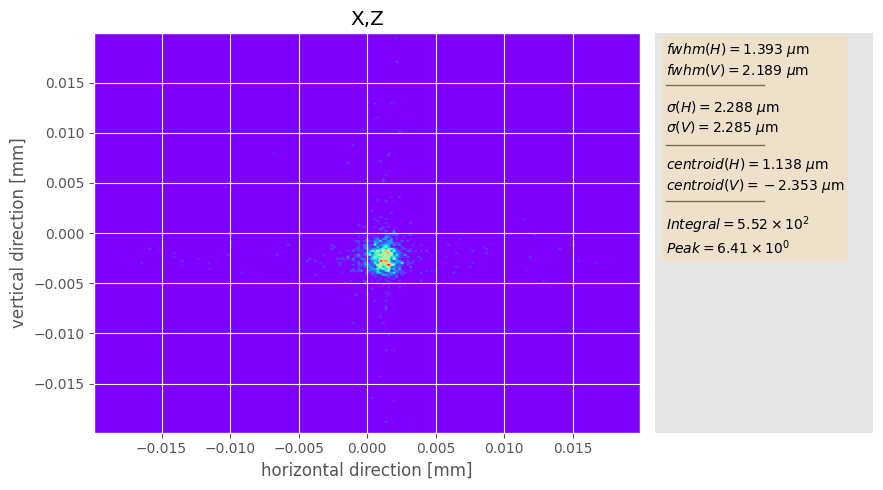

[0.011148174600586824, 0.0028443841422906846]


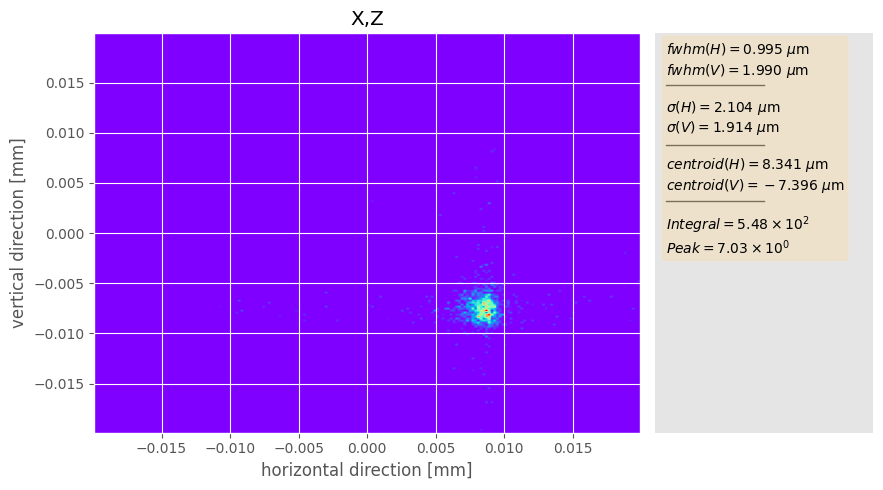

[0.0062666695725222005, 0.0032216446556913125]


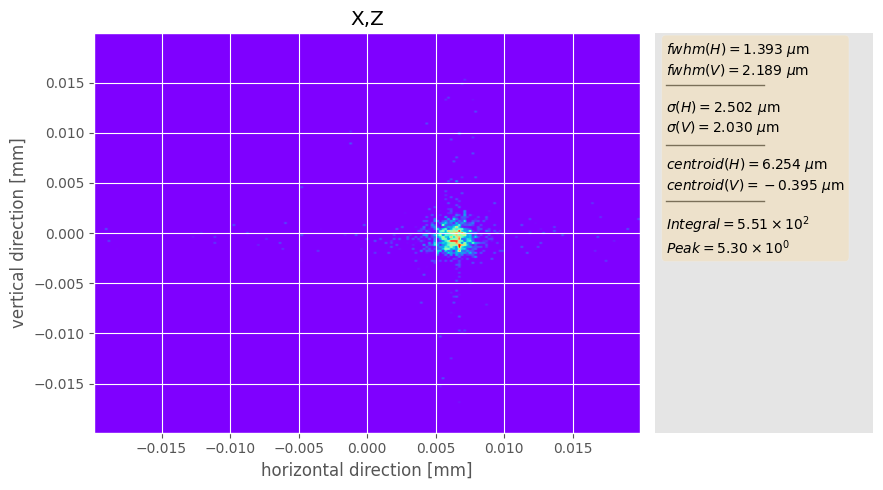

[0.006460368130963853, 0.0030264047845497476]


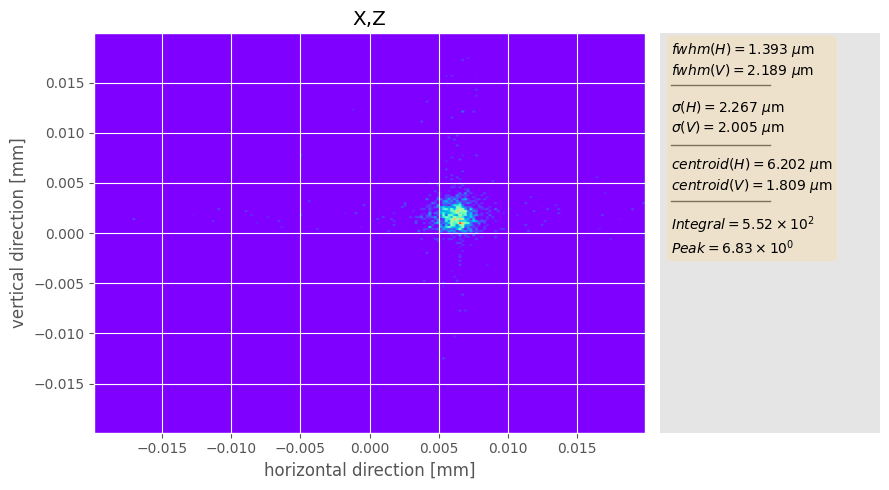

[0.013705492411732214, 0.002728835969920155]


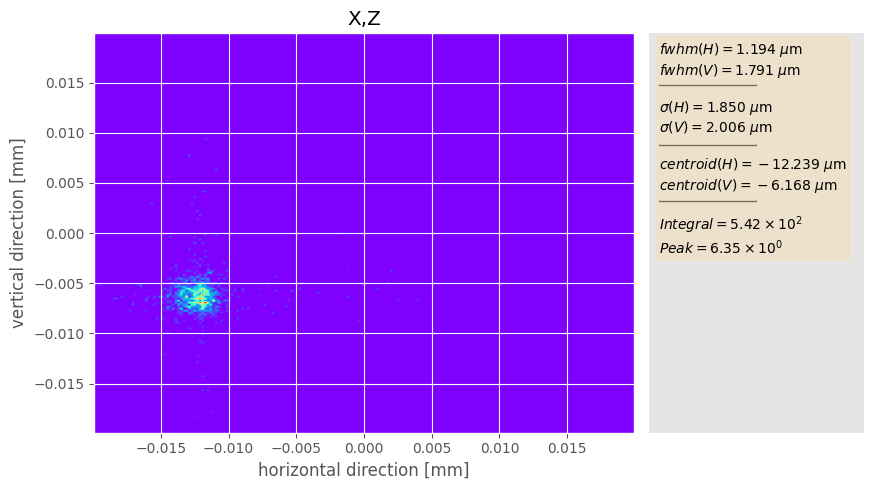

In [102]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [103]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-12 23:42:25,049] Trial 100 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:28,039] Trial 101 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:30,767] Trial 102 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:32,678] Trial 103 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:34,446] Trial 104 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:37,082] Trial 105 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:38,682] Trial 106 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:41,356] Trial 107 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:43,146] Trial 108 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:45,910] Trial 109 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:48,452] Trial 110 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:50,132] Trial 111 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:53,220] Trial 112 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:55,732] Trial 113 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:42:58,472] Trial 114 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:01,541] Trial 115 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:04,031] Trial 116 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:06,781] Trial 117 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:09,673] Trial 118 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:11,595] Trial 119 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:14,198] Trial 120 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:16,763] Trial 121 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:19,708] Trial 122 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:21,578] Trial 123 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:24,436] Trial 124 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:26,199] Trial 125 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:27,828] Trial 126 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:30,642] Trial 127 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:33,639] Trial 128 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:35,297] Trial 129 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:36,875] Trial 130 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:39,525] Trial 131 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:41,284] Trial 132 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:44,053] Trial 133 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:46,373] Trial 134 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:48,185] Trial 135 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:50,064] Trial 136 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:52,613] Trial 137 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:54,292] Trial 138 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:55,896] Trial 139 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:57,596] Trial 140 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:43:59,391] Trial 141 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:01,905] Trial 142 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:04,491] Trial 143 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:06,262] Trial 144 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:08,045] Trial 145 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:09,975] Trial 146 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:12,407] Trial 147 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:14,836] Trial 148 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:16,979] Trial 149 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:18,653] Trial 150 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:20,365] Trial 151 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:22,148] Trial 152 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:23,813] Trial 153 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:25,651] Trial 154 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:28,118] Trial 155 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:31,094] Trial 156 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:32,963] Trial 157 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:34,666] Trial 158 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:36,271] Trial 159 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:38,944] Trial 160 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:40,745] Trial 161 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:43,539] Trial 162 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:46,244] Trial 163 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

[I 2022-10-12 23:44:48,867] Trial 164 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.


[W 2022-10-12 23:44:49,505] Trial 165 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_29909/3298524706.py", line 44, in _objective
    loss = self._loss_fn_this(current_params)
  File "/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/common.py", line 341, in loss
    self.current_loss = self.opt_common.loss_function(x_relative_this, verbose=False)
  File "/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/common.py", line 466, in loss_function
    self._update_beam_state()
  File "/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/common.py", line 423, in _update_beam_state
    (current_be

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_29909/4193629308.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


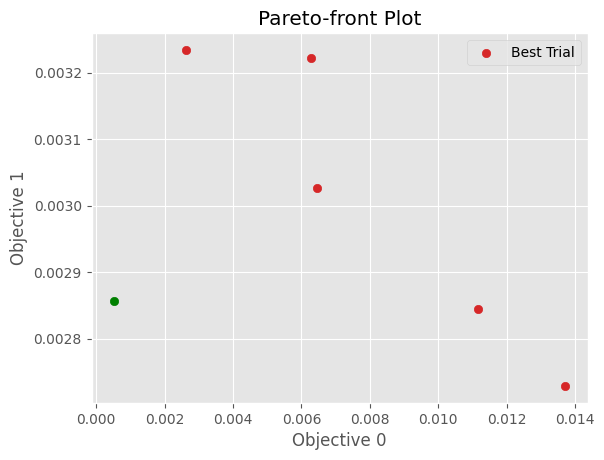

In [104]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)

plt.scatter(centroid_ground, sigma_ground, color='green')
#plt.xscale('log')
#plt.yscale('log')

In [105]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-11.68112455170668
-10.358888212463786
-10.810373521297704
-10.842448880303003
-10.193838765881207


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-16946

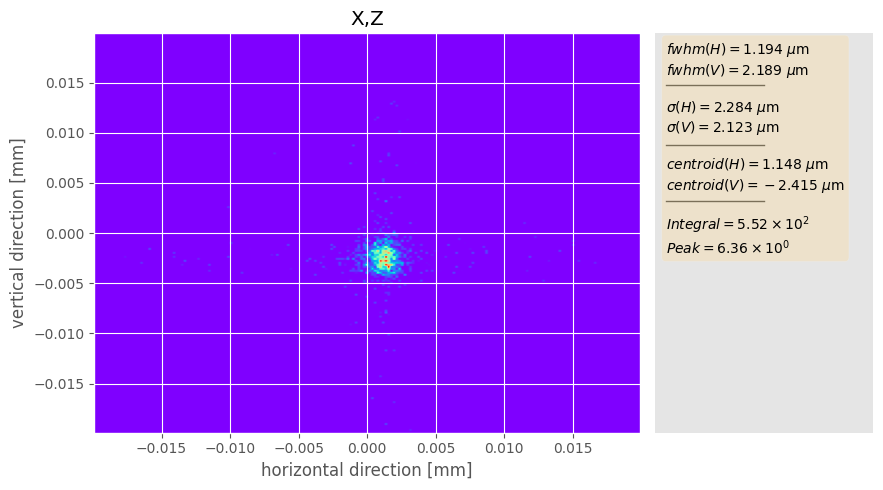

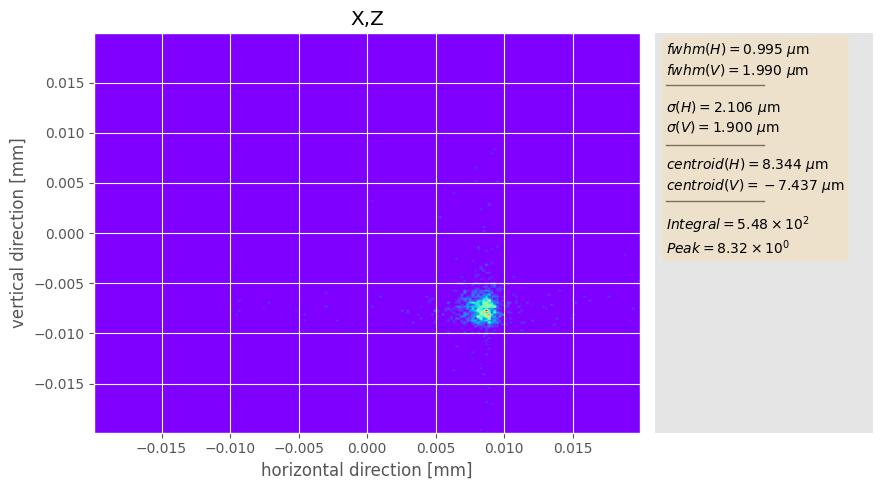

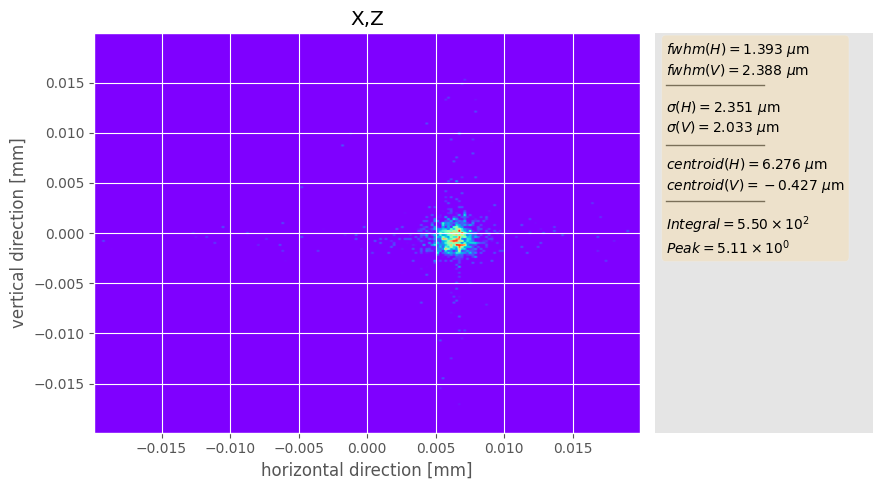

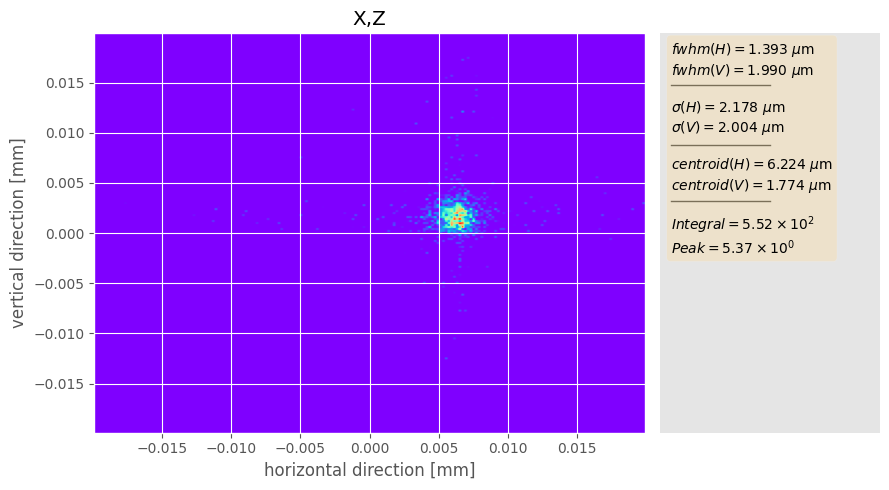

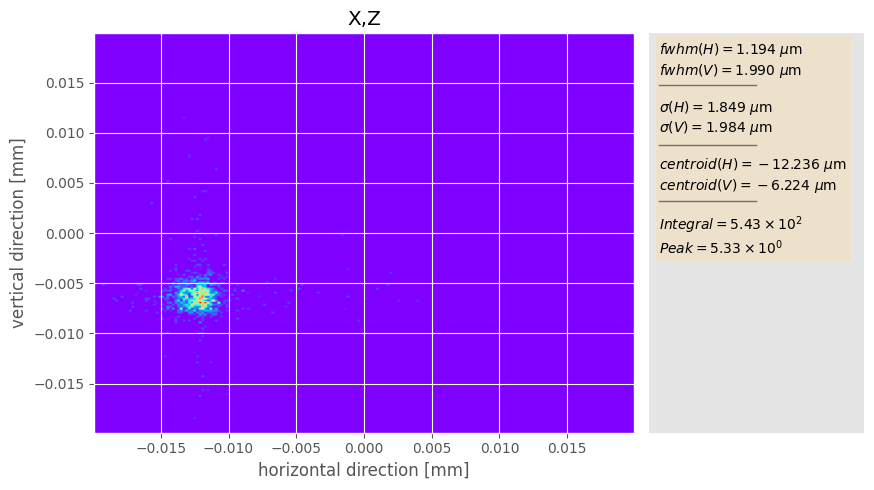

In [106]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [98]:
opt_trial.trials(200)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:23,339] Trial 311 finished with values: [0.013395584416043637, 0.004013962065060026] and parameters: {'hkb_1': 35.325199999999995, 'vkb_1': -5.435100000000006, 'hkb_2': -43.9567, 'vkb_2': 21.0813, 'hkb_3': 0.036794487087750495, 'vkb_3': -0.010329402716096399, 'hkb_4': -9.2, 'vkb_4': -11.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:24,776] Trial 312 finished with values: [0.02390262266600484, 0.005427325330509642] and parameters: {'hkb_1': 2.617199999999997, 'vkb_1': 49.403999999999996, 'hkb_2': 7.851599999999998, 'vkb_2': 12.313199999999995, 'hkb_3': 0.03504915783575618, 'vkb_3': -0.00509341496011341, 'hkb_4': -8.299999999999997, 'vkb_4': -25.8}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:27,285] Trial 313 finished with values: [0.027879818892695044, 0.0036994811227998854] and parameters: {'hkb_1': 2.7445999999999984, 'vkb_1': 27.463499999999996, 'hkb_2': 4.923999999999992, 'vkb_2': 5.249199999999995, 'hkb_3': 0.03504915783575618, 'vkb_3': -0.04, 'hkb_4': 0.7000000000000028, 'vkb_4': -12.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:28,520] Trial 314 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 5.114999999999995, 'vkb_1': -3.0423000000000044, 'hkb_2': 15.964099999999988, 'vkb_2': -2.386400000000002, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.014105206811824214, 'hkb_4': -29.0, 'vkb_4': 19.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:31,232] Trial 315 finished with values: [0.03282422676704875, 0.0034556118989721466] and parameters: {'hkb_1': 9.336799999999997, 'vkb_1': 2.778499999999994, 'hkb_2': 3.0762999999999963, 'vkb_2': 14.362499999999997, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.029528024488034023, 'hkb_4': 12.100000000000001, 'vkb_4': -10.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:33,042] Trial 316 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -17.971900000000005, 'vkb_1': -40.887100000000004, 'hkb_2': -2.4391000000000034, 'vkb_2': -4.904600000000002, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.0071238898038469, 'hkb_4': -10.799999999999997, 'vkb_4': 29.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:35,090] Trial 317 finished with values: [0.018248752305701797, 0.004461667471036865] and parameters: {'hkb_1': -42.6006, 'vkb_1': -46.2124, 'hkb_2': -34.2763, 'vkb_2': 2.7143999999999977, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.0245771823237902, 'hkb_4': 4.0, 'vkb_4': -11.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:37,987] Trial 318 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -26.740000000000002, 'vkb_1': -2.475500000000004, 'hkb_2': 34.4302, 'vkb_2': -43.4872, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.036509341496011344, 'hkb_4': -11.599999999999998, 'vkb_4': 17.400000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:40,436] Trial 319 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 11.746099999999991, 'vkb_1': -6.299000000000007, 'hkb_2': -47.2065, 'vkb_2': 6.555399999999992, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.033303828583761845, 'hkb_4': -10.0, 'vkb_4': -29.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:42,875] Trial 320 finished with values: [0.030615826898541258, 0.0044565899782792705] and parameters: {'hkb_1': -5.625400000000006, 'vkb_1': -2.385400000000004, 'hkb_2': 6.678199999999997, 'vkb_2': 19.724099999999993, 'hkb_3': -0.012074731968090727, 'vkb_3': 0.014105206811824214, 'hkb_4': 9.0, 'vkb_4': 5.600000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:44,308] Trial 321 finished with values: [0.0053896579484956, 0.0033542317853162053] and parameters: {'hkb_1': -2.612700000000004, 'vkb_1': -26.686300000000003, 'hkb_2': 4.360299999999995, 'vkb_2': 2.5463999999999984, 'hkb_3': 0.03853981633974483, 'vkb_3': 0.005378560551852568, 'hkb_4': -8.099999999999998, 'vkb_4': -9.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:45,855] Trial 322 finished with values: [0.007538565225311637, 0.003736921235205112] and parameters: {'hkb_1': -4.859000000000002, 'vkb_1': -23.671200000000002, 'hkb_2': -18.701600000000003, 'vkb_2': 2.2609999999999957, 'hkb_3': 0.03853981633974483, 'vkb_3': 0.0001425727958695791, 'hkb_4': -8.299999999999997, 'vkb_4': -9.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:47,291] Trial 323 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -2.813900000000004, 'vkb_1': -30.690900000000003, 'hkb_2': 2.3999999999999986, 'vkb_2': -2.4048000000000016, 'hkb_3': 0.03853981633974483, 'vkb_3': -0.003348085708119078, 'hkb_4': 29.700000000000003, 'vkb_4': -9.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:48,672] Trial 324 finished with values: [0.011274178591605979, 0.0034337338769999176] and parameters: {'hkb_1': -2.5838000000000036, 'vkb_1': -32.98950000000001, 'hkb_2': 3.142799999999994, 'vkb_2': -3.649400000000007, 'hkb_3': 0.036794487087750495, 'vkb_3': 0.005378560551852568, 'hkb_4': -12.0, 'vkb_4': 1.8000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:50,401] Trial 325 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -4.386800000000001, 'vkb_1': -28.689000000000004, 'hkb_2': -12.538300000000007, 'vkb_2': 27.51769999999999, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.001887902047863911, 'hkb_4': 23.5, 'vkb_4': -23.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:54,342] Trial 326 finished with values: [0.014590930419223857, 0.0040157974054952665] and parameters: {'hkb_1': -7.560700000000004, 'vkb_1': -24.987900000000003, 'hkb_2': -5.144100000000002, 'vkb_2': -34.2542, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.02981317007977318, 'hkb_4': -9.0, 'vkb_4': -11.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:30:57,285] Trial 327 finished with values: [0.011973979683503147, 0.003249171974991534] and parameters: {'hkb_1': 41.115399999999994, 'vkb_1': -26.748900000000003, 'hkb_2': 4.260399999999997, 'vkb_2': -2.2797000000000054, 'hkb_3': -0.017310719724073716, 'vkb_3': -0.0016027564561247529, 'hkb_4': -10.7, 'vkb_4': -13.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:00,106] Trial 328 finished with values: [0.01346244820772489, 0.003375143475626994] and parameters: {'hkb_1': 41.50529999999999, 'vkb_1': -27.8058, 'hkb_2': 6.178599999999996, 'vkb_2': -2.7216000000000022, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.0016027564561247529, 'hkb_4': -10.2, 'vkb_4': -15.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:03,489] Trial 329 finished with values: [0.015464386456570774, 0.003532179764487574] and parameters: {'hkb_1': 32.992299999999986, 'vkb_1': -27.646600000000003, 'hkb_2': 10.078599999999994, 'vkb_2': -6.964200000000005, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.003348085708119078, 'hkb_4': -10.5, 'vkb_4': -14.299999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:06,356] Trial 330 finished with values: [0.010865788912000896, 0.003537459590596313] and parameters: {'hkb_1': 41.320499999999996, 'vkb_1': -26.442000000000004, 'hkb_2': 4.559599999999996, 'vkb_2': -8.120800000000003, 'hkb_3': -0.015565390472079388, 'vkb_3': 0.0001425727958695791, 'hkb_4': -11.899999999999999, 'vkb_4': -13.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:09,087] Trial 331 finished with values: [0.011064900775230396, 0.004724179157681113] and parameters: {'hkb_1': 32.09599999999999, 'vkb_1': -20.724800000000002, 'hkb_2': 7.716899999999995, 'vkb_2': -5.758600000000001, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.0016027564561247529, 'hkb_4': -12.399999999999999, 'vkb_4': -14.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:12,550] Trial 332 finished with values: [0.01823188883460987, 0.0036853451448963345] and parameters: {'hkb_1': 39.64439999999999, 'vkb_1': -25.3834, 'hkb_2': 5.008199999999995, 'vkb_2': -4.031100000000002, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.003348085708119078, 'hkb_4': -9.799999999999997, 'vkb_4': -17.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:15,365] Trial 333 finished with values: [0.012001224011481454, 0.004722018470603965] and parameters: {'hkb_1': 35.908199999999994, 'vkb_1': -30.1036, 'hkb_2': 6.403899999999993, 'vkb_2': -2.6589000000000027, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.00509341496011341, 'hkb_4': -10.799999999999997, 'vkb_4': -12.8}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:18,358] Trial 334 finished with values: [0.014642441382267142, 0.003563313288979782] and parameters: {'hkb_1': 45.75649999999999, 'vkb_1': -27.020400000000002, 'hkb_2': 2.487799999999993, 'vkb_2': -5.753600000000006, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.0001425727958695791, 'hkb_4': -8.899999999999999, 'vkb_4': -15.799999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:20,840] Trial 335 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 28.75609999999999, 'vkb_1': -22.7708, 'hkb_2': 4.561199999999992, 'vkb_2': -4.764900000000004, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.0016027564561247529, 'hkb_4': 14.600000000000001, 'vkb_4': -12.3}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:24,019] Trial 336 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 44.35929999999999, 'vkb_1': -25.303600000000003, 'hkb_2': 8.286599999999993, 'vkb_2': -3.2630000000000052, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.0001425727958695791, 'hkb_4': 27.1, 'vkb_4': -13.3}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:27,113] Trial 337 finished with values: [0.011726030264098533, 0.004537331384256758] and parameters: {'hkb_1': 47.203599999999994, 'vkb_1': -30.6006, 'hkb_2': 2.448299999999996, 'vkb_2': -2.3463000000000065, 'hkb_3': -0.015565390472079388, 'vkb_3': -0.006838744212107742, 'hkb_4': -11.3, 'vkb_4': -11.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:29,992] Trial 338 finished with values: [0.01241445798451778, 0.004512102819642029] and parameters: {'hkb_1': 37.14529999999999, 'vkb_1': -27.9658, 'hkb_2': -39.8962, 'vkb_2': -2.2476000000000056, 'hkb_3': -0.017310719724073716, 'vkb_3': -0.0016027564561247529, 'hkb_4': -12.5, 'vkb_4': -14.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:32,568] Trial 339 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 30.876099999999994, 'vkb_1': -24.6734, 'hkb_2': 12.256899999999995, 'vkb_2': 2.5368999999999957, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.001887902047863911, 'hkb_4': 17.0, 'vkb_4': -13.3}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:34,506] Trial 340 finished with values: [0.005040525222253092, 0.0032497043851038845] and parameters: {'hkb_1': 26.31729999999999, 'vkb_1': -29.472700000000003, 'hkb_2': 2.701199999999993, 'vkb_2': 34.84169999999999, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.003633231299858236, 'hkb_4': -7.699999999999999, 'vkb_4': -9.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:36,534] Trial 341 finished with values: [0.005545481495575522, 0.0036162433876108457] and parameters: {'hkb_1': 25.962699999999998, 'vkb_1': -30.8321, 'hkb_2': -2.7720000000000056, 'vkb_2': 46.517099999999985, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.005378560551852568, 'hkb_4': -7.099999999999998, 'vkb_4': -9.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:38,461] Trial 342 finished with values: [0.005041398372460029, 0.003243546813242983] and parameters: {'hkb_1': 23.878899999999987, 'vkb_1': -31.8713, 'hkb_2': 2.4366999999999948, 'vkb_2': 33.64259999999999, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.003633231299858236, 'hkb_4': -7.699999999999999, 'vkb_4': -9.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:41,020] Trial 343 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 24.410999999999987, 'vkb_1': -36.8298, 'hkb_2': 37.63109999999999, 'vkb_2': 38.51759999999999, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.024292036732051034, 'hkb_4': -21.4, 'vkb_4': 20.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:43,541] Trial 344 finished with values: [0.02742040334122986, 0.004429250704367659] and parameters: {'hkb_1': -12.290100000000002, 'vkb_1': 8.473699999999994, 'hkb_2': 45.36999999999999, 'vkb_2': 40.49619999999999, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.03504915783575618, 'hkb_4': 7.0, 'vkb_4': -0.6999999999999993}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:45,552] Trial 345 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 16.2239, 'vkb_1': 24.658299999999997, 'hkb_2': 22.38629999999999, 'vkb_2': 33.69829999999999, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.015850536063818546, 'hkb_4': 18.6, 'vkb_4': 10.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:48,491] Trial 346 finished with values: [0.0285692183962507, 0.0051898550768582985] and parameters: {'hkb_1': 20.971099999999993, 'vkb_1': 37.2076, 'hkb_2': -2.6417000000000073, 'vkb_2': 25.1588, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.03301868299202268, 'hkb_4': -12.5, 'vkb_4': -20.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:50,683] Trial 347 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -49.5909, 'vkb_1': 4.900699999999993, 'hkb_2': -37.8248, 'vkb_2': -21.434700000000003, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.015565390472079388, 'hkb_4': 20.400000000000006, 'vkb_4': 13.100000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:52,820] Trial 348 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -45.4664, 'vkb_1': 46.93129999999999, 'hkb_2': -6.6019000000000005, 'vkb_2': -27.332900000000002, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.022831853071795867, 'hkb_4': -24.1, 'vkb_4': -9.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:54,508] Trial 349 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 24.319199999999995, 'vkb_1': 43.41749999999999, 'hkb_2': -30.9329, 'vkb_2': 49.80829999999999, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.017595865315812878, 'hkb_4': 10.400000000000006, 'vkb_4': 24.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:56,442] Trial 350 finished with values: [0.0049433016426835815, 0.00963297262354011] and parameters: {'hkb_1': 2.689399999999992, 'vkb_1': 2.368299999999998, 'hkb_2': 29.26809999999999, 'vkb_2': 35.728899999999996, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.014105206811824214, 'hkb_4': -9.899999999999999, 'vkb_4': -27.8}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:31:58,906] Trial 351 finished with values: [0.014729683848609846, 0.004605927161454091] and parameters: {'hkb_1': -36.440200000000004, 'vkb_1': -34.3805, 'hkb_2': -5.3489, 'vkb_2': -40.7468, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.019056048976068045, 'hkb_4': -11.8, 'vkb_4': -9.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:01,522] Trial 352 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -22.3411, 'vkb_1': 2.868799999999993, 'hkb_2': -2.078400000000002, 'vkb_2': 18.877199999999988, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.027782695236039694, 'hkb_4': -25.2, 'vkb_4': 15.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:03,337] Trial 353 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -16.856300000000005, 'vkb_1': -40.8803, 'hkb_2': 41.780399999999986, 'vkb_2': -23.917600000000004, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.014105206811824214, 'hkb_4': 24.400000000000006, 'vkb_4': 27.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:05,952] Trial 354 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -2.5339000000000027, 'vkb_1': 6.191299999999998, 'hkb_2': -2.8289000000000044, 'vkb_2': -36.4417, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.022546707480056705, 'hkb_4': -22.9, 'vkb_4': 7.600000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:07,366] Trial 355 finished with values: [0.011016047715124893, 0.00396680213091525] and parameters: {'hkb_1': 2.625399999999992, 'vkb_1': 10.770999999999994, 'hkb_2': -5.121000000000002, 'vkb_2': 2.3445999999999927, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.015850536063818546, 'hkb_4': 2.5, 'vkb_4': -10.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:09,376] Trial 356 finished with values: [0.01961407533782544, 0.007596532494272106] and parameters: {'hkb_1': -15.137800000000006, 'vkb_1': -2.242600000000003, 'hkb_2': -9.6918, 'vkb_2': -32.423100000000005, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.014105206811824214, 'hkb_4': 5.0, 'vkb_4': -22.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:11,285] Trial 357 finished with values: [0.01591344517311707, 0.009072142885985741] and parameters: {'hkb_1': -10.792000000000002, 'vkb_1': 13.953899999999997, 'hkb_2': -13.026100000000007, 'vkb_2': -30.741500000000002, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.014105206811824214, 'hkb_4': -8.599999999999998, 'vkb_4': 11.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:13,095] Trial 358 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -28.313000000000002, 'vkb_1': -17.476800000000004, 'hkb_2': -22.585700000000003, 'vkb_2': 31.108199999999997, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.0071238898038469, 'hkb_4': -12.5, 'vkb_4': 22.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:15,632] Trial 359 finished with values: [0.010915194186106585, 0.009442675288134642] and parameters: {'hkb_1': 22.412099999999995, 'vkb_1': 20.32889999999999, 'hkb_2': -24.489400000000003, 'vkb_2': 13.965499999999992, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.036794487087750495, 'hkb_4': -16.7, 'vkb_4': -9.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:17,869] Trial 360 finished with values: [0.00456312403378387, 0.004711326832064588] and parameters: {'hkb_1': 19.549299999999988, 'vkb_1': -14.264100000000006, 'hkb_2': 2.3185999999999964, 'vkb_2': -12.360300000000002, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.026322511575784517, 'hkb_4': -11.599999999999998, 'vkb_4': -10.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:20,128] Trial 361 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 14.2787, 'vkb_1': 2.4808999999999983, 'hkb_2': -33.2812, 'vkb_2': -38.8124, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.013820061220085056, 'hkb_4': -19.799999999999997, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:21,678] Trial 362 finished with values: [0.024250483486412146, 0.00562113712010196] and parameters: {'hkb_1': -2.278400000000005, 'vkb_1': 22.808099999999996, 'hkb_2': -18.529500000000002, 'vkb_2': 3.984799999999993, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.003633231299858236, 'hkb_4': 11.700000000000003, 'vkb_4': 3.3000000000000043}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:24,806] Trial 363 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -24.6031, 'vkb_1': 5.841999999999992, 'hkb_2': -28.586000000000002, 'vkb_2': 26.5325, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.015850536063818546, 'hkb_4': 25.900000000000006, 'vkb_4': 16.800000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:26,404] Trial 364 finished with values: [0.005451781947943279, 0.004530202039979123] and parameters: {'hkb_1': -19.955000000000002, 'vkb_1': 3.9588999999999928, 'hkb_2': -44.9643, 'vkb_2': 10.309499999999993, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.019341194567807203, 'hkb_4': -9.799999999999997, 'vkb_4': -8.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:28,450] Trial 365 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -32.639300000000006, 'vkb_1': 18.144099999999995, 'hkb_2': -2.257800000000003, 'vkb_2': -15.975900000000003, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.0071238898038469, 'hkb_4': -28.3, 'vkb_4': -11.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:29,995] Trial 366 finished with values: [0.0027512673065582427, 0.004262949496536329] and parameters: {'hkb_1': -39.162, 'vkb_1': 28.400699999999986, 'hkb_2': 31.92989999999999, 'vkb_2': 2.2589999999999932, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.014105206811824214, 'hkb_4': -10.599999999999998, 'vkb_4': -10.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:32,730] Trial 367 finished with values: [0.033990810102003624, 0.005172130071142742] and parameters: {'hkb_1': -5.0638000000000005, 'vkb_1': -2.296900000000001, 'hkb_2': 2.3149999999999977, 'vkb_2': -19.780500000000004, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.031273353740028355, 'hkb_4': 13.600000000000001, 'vkb_4': -9.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:35,746] Trial 368 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': -2.4414000000000016, 'vkb_1': 2.4462999999999937, 'hkb_2': 16.515599999999992, 'vkb_2': -43.7602, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.036509341496011344, 'hkb_4': -6.099999999999998, 'vkb_4': 6.100000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:39,442] Trial 369 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 2.5908999999999978, 'vkb_1': -2.8263000000000034, 'hkb_2': -2.1197000000000017, 'vkb_2': 44.256399999999985, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.014105206811824214, 'hkb_4': -29.9, 'vkb_4': -18.9}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:41,293] Trial 370 finished with values: [0.021808972617817512, 0.00649102973502576] and parameters: {'hkb_1': -6.955700000000007, 'vkb_1': -49.277, 'hkb_2': -4.212500000000006, 'vkb_2': 4.722399999999993, 'hkb_3': 0.026322511575784517, 'vkb_3': -0.012074731968090727, 'hkb_4': -8.099999999999998, 'vkb_4': -21.4}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:43,197] Trial 371 finished with values: [0.0008093553420972892, 0.003930060530247443] and parameters: {'hkb_1': 28.553299999999993, 'vkb_1': -38.5814, 'hkb_2': 3.759699999999995, 'vkb_2': 2.339899999999993, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.014105206811824214, 'hkb_4': -11.3, 'vkb_4': -10.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:45,483] Trial 372 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 17.290999999999997, 'vkb_1': -38.7838, 'hkb_2': 9.387099999999997, 'vkb_2': 7.4805999999999955, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.021086523819801535, 'hkb_4': -27.1, 'vkb_4': -12.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:47,581] Trial 373 finished with values: [0.021663414921588298, 0.0031583006133804326] and parameters: {'hkb_1': 28.902199999999993, 'vkb_1': -43.1266, 'hkb_2': 6.757699999999993, 'vkb_2': 5.128999999999998, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.019341194567807203, 'hkb_4': 8.200000000000003, 'vkb_4': -12.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:51,074] Trial 374 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 29.679999999999993, 'vkb_1': -46.235, 'hkb_2': 6.534999999999997, 'vkb_2': 6.009299999999996, 'hkb_3': -0.031273353740028355, 'vkb_3': 0.019341194567807203, 'hkb_4': -0.5, 'vkb_4': -29.8}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:53,191] Trial 375 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 27.110699999999994, 'vkb_1': -42.9672, 'hkb_2': 7.945699999999995, 'vkb_2': 7.0674999999999955, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.022831853071795867, 'hkb_4': 16.6, 'vkb_4': 9.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:55,283] Trial 376 finished with values: [0.014538418711410516, 0.0033266791590056315] and parameters: {'hkb_1': 31.008399999999995, 'vkb_1': -39.7862, 'hkb_2': 5.595899999999993, 'vkb_2': 5.335599999999992, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.019341194567807203, 'hkb_4': 1.9000000000000021, 'vkb_4': -11.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:57,424] Trial 377 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 28.956999999999994, 'vkb_1': -36.368700000000004, 'hkb_2': 10.096699999999991, 'vkb_2': 5.064899999999994, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.017595865315812878, 'hkb_4': -11.3, 'vkb_4': -26.3}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:32:58,857] Trial 378 finished with values: [0.015132084222551138, 0.003860640450274006] and parameters: {'hkb_1': 25.9028, 'vkb_1': -42.6754, 'hkb_2': 4.669099999999993, 'vkb_2': 4.678699999999992, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.022831853071795867, 'hkb_4': 7.700000000000003, 'vkb_4': -12.8}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:01,198] Trial 379 finished with values: [0.002447954197463369, 0.016965620718303313] and parameters: {'hkb_1': 27.88499999999999, 'vkb_1': -38.6708, 'hkb_2': 7.460299999999997, 'vkb_2': 7.501199999999997, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.021086523819801535, 'hkb_4': 28.700000000000003, 'vkb_4': -11.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:03,697] Trial 380 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 30.46889999999999, 'vkb_1': -34.611900000000006, 'hkb_2': 5.063499999999998, 'vkb_2': -46.4816, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.017595865315812878, 'hkb_4': -26.1, 'vkb_4': -12.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:05,477] Trial 381 finished with values: [0.0202845833280583, 0.0056454114467896594] and parameters: {'hkb_1': 31.8035, 'vkb_1': -45.4698, 'hkb_2': 6.790799999999997, 'vkb_2': 3.8961999999999932, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.026322511575784517, 'hkb_4': -11.0, 'vkb_4': 4.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:07,778] Trial 382 finished with values: [0.003530896547670757, 0.004433993797363408] and parameters: {'hkb_1': 27.159899999999993, 'vkb_1': -41.5522, 'hkb_2': 4.523099999999992, 'vkb_2': 2.564399999999992, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.019341194567807203, 'hkb_4': -9.599999999999998, 'vkb_4': -14.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:11,587] Trial 383 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 28.263999999999996, 'vkb_1': -44.419, 'hkb_2': 12.948899999999995, 'vkb_2': -24.656900000000004, 'hkb_3': -0.04, 'vkb_3': 0.02981317007977318, 'hkb_4': 19.1, 'vkb_4': -1.6999999999999993}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:13,028] Trial 384 finished with values: [0.005444800097089109, 0.017019232495533276] and parameters: {'hkb_1': 25.66069999999999, 'vkb_1': -37.903400000000005, 'hkb_2': 8.555499999999995, 'vkb_2': 5.915999999999997, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.0245771823237902, 'hkb_4': -10.799999999999997, 'vkb_4': 19.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-23 16:33:14,628] Trial 385 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 29.278699999999986, 'vkb_1': -33.1135, 'hkb_2': 5.950899999999997, 'vkb_2': 10.888099999999994, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.017595865315812878, 'hkb_4': 22.900000000000006, 'vkb_4': -24.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:16,665] Trial 386 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 33.73339999999999, 'vkb_1': -47.687, 'hkb_2': 5.155499999999996, 'vkb_2': 8.384799999999991, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.021086523819801535, 'hkb_4': 21.1, 'vkb_4': -10.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:20,310] Trial 387 finished with values: [0.008599469818123286, 0.003477429681825928] and parameters: {'hkb_1': 30.838199999999986, 'vkb_1': -36.6368, 'hkb_2': 10.719499999999996, 'vkb_2': 23.648899999999998, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.017595865315812878, 'hkb_4': -12.8, 'vkb_4': -12.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:22,439] Trial 388 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 26.268599999999992, 'vkb_1': -41.8866, 'hkb_2': 4.748099999999994, 'vkb_2': 4.596399999999996, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.02806784082777885, 'hkb_4': 14.100000000000001, 'vkb_4': 25.800000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:25,128] Trial 389 finished with values: [0.03203077736813162, 0.006875231162823318] and parameters: {'hkb_1': 29.187999999999988, 'vkb_1': -35.0471, 'hkb_2': -20.222500000000004, 'vkb_2': 3.2497999999999934, 'hkb_3': 0.001887902047863911, 'vkb_3': -0.020801378228062377, 'hkb_4': 15.5, 'vkb_4': -10.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:27,162] Trial 390 finished with values: [0.0026113108249056225, 0.004152271655075212] and parameters: {'hkb_1': 23.772299999999987, 'vkb_1': -39.284800000000004, 'hkb_2': 3.759299999999996, 'vkb_2': 6.5312999999999946, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.021086523819801535, 'hkb_4': -12.3, 'vkb_4': -11.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:30,693] Trial 391 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 33.03769999999999, 'vkb_1': -33.286699999999996, 'hkb_2': 14.404599999999988, 'vkb_2': 2.308799999999998, 'hkb_3': -0.027782695236039694, 'vkb_3': 0.0245771823237902, 'hkb_4': -11.2, 'vkb_4': 28.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:33,158] Trial 392 finished with values: [0.025340506545607933, 0.0033213550082371013] and parameters: {'hkb_1': 26.803999999999988, 'vkb_1': -44.7841, 'hkb_2': -42.8248, 'vkb_2': 4.599699999999999, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.019341194567807203, 'hkb_4': 8.800000000000004, 'vkb_4': -12.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:34,831] Trial 393 finished with values: [0.02583534761904877, 0.008734332920961528] and parameters: {'hkb_1': 29.938299999999998, 'vkb_1': -37.9942, 'hkb_2': 8.762599999999992, 'vkb_2': 44.38459999999999, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.022831853071795867, 'hkb_4': -18.299999999999997, 'vkb_4': -16.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:37,493] Trial 394 finished with values: [0.02350393701752444, 0.004408854567480337] and parameters: {'hkb_1': 28.93759999999999, 'vkb_1': -40.2648, 'hkb_2': -36.2087, 'vkb_2': 2.485199999999992, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.03853981633974483, 'hkb_4': -9.0, 'vkb_4': 1.8000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:41,084] Trial 395 finished with values: [0.025849267121572952, 0.00338074759450891] and parameters: {'hkb_1': 32.260099999999994, 'vkb_1': -43.0795, 'hkb_2': -15.5578, 'vkb_2': 8.535199999999996, 'hkb_3': -0.003348085708119078, 'vkb_3': -0.03825467074800567, 'hkb_4': -3.8999999999999986, 'vkb_4': -10.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:43,335] Trial 396 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 27.5586, 'vkb_1': -36.1856, 'hkb_2': 2.651699999999998, 'vkb_2': 2.161699999999996, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.010329402716096399, 'hkb_4': -7.699999999999999, 'vkb_4': 18.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:45,244] Trial 397 finished with values: [0.018833296888676097, 0.013542227851031874] and parameters: {'hkb_1': 25.163299999999992, 'vkb_1': -32.4901, 'hkb_2': 23.2941, 'vkb_2': -29.225, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.015850536063818546, 'hkb_4': 5.899999999999999, 'vkb_4': 16.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:47,808] Trial 398 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 27.704899999999995, 'vkb_1': -41.6245, 'hkb_2': 36.80969999999999, 'vkb_2': 15.75869999999999, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.003633231299858236, 'hkb_4': -10.099999999999998, 'vkb_4': 13.900000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:49,935] Trial 399 finished with values: [0.016749354314627204, 0.0031653504280989165] and parameters: {'hkb_1': 30.669299999999993, 'vkb_1': -38.9453, 'hkb_2': 6.926699999999997, 'vkb_2': 30.693099999999987, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.015850536063818546, 'hkb_4': 3.6000000000000014, 'vkb_4': -11.8}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:52,131] Trial 400 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 35.376099999999994, 'vkb_1': -37.7152, 'hkb_2': 39.666, 'vkb_2': 35.455299999999994, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.015850536063818546, 'hkb_4': 3.3000000000000043, 'vkb_4': 29.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:54,286] Trial 401 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 31.463399999999993, 'vkb_1': -34.8217, 'hkb_2': -47.6801, 'vkb_2': 19.78989999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.015850536063818546, 'hkb_4': 1.2000000000000028, 'vkb_4': 23.400000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:56,337] Trial 402 finished with values: [0.0021649593825930173, 0.01781609888795364] and parameters: {'hkb_1': 23.56349999999999, 'vkb_1': -39.6338, 'hkb_2': 6.776299999999992, 'vkb_2': 27.963499999999996, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.015850536063818546, 'hkb_4': 25.900000000000006, 'vkb_4': -13.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:33:58,761] Trial 403 finished with values: [0.0019892406330575727, 0.00339942608653454] and parameters: {'hkb_1': 25.88409999999999, 'vkb_1': -44.1152, 'hkb_2': 46.6348, 'vkb_2': 39.2923, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.017595865315812878, 'hkb_4': -12.599999999999998, 'vkb_4': -11.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:01,200] Trial 404 finished with values: [0.002119049072168727, 0.004941828788634255] and parameters: {'hkb_1': 21.6147, 'vkb_1': -47.7144, 'hkb_2': 35.288099999999986, 'vkb_2': 39.03349999999999, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.017595865315812878, 'hkb_4': -12.7, 'vkb_4': -13.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:03,640] Trial 405 finished with values: [0.0018231939951777322, 0.0033170587353669044] and parameters: {'hkb_1': 25.293999999999997, 'vkb_1': -46.1226, 'hkb_2': 47.06609999999999, 'vkb_2': 42.60449999999999, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.017595865315812878, 'hkb_4': -12.599999999999998, 'vkb_4': -11.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:05,916] Trial 406 finished with values: [0.01871314611634937, 0.002682177332396714] and parameters: {'hkb_1': 24.91659999999999, 'vkb_1': -49.8786, 'hkb_2': 48.6181, 'vkb_2': 47.615999999999985, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.015850536063818546, 'hkb_4': 4.5, 'vkb_4': -9.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:08,268] Trial 407 finished with values: [0.019641476984114514, 0.002863645350640527] and parameters: {'hkb_1': 23.21969999999999, 'vkb_1': -49.6618, 'hkb_2': 46.388999999999996, 'vkb_2': 47.56009999999999, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.017595865315812878, 'hkb_4': 4.800000000000004, 'vkb_4': -8.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:10,604] Trial 408 finished with values: [0.018897442492509346, 0.0027836004214276734] and parameters: {'hkb_1': 24.634199999999993, 'vkb_1': -46.4458, 'hkb_2': 46.48889999999999, 'vkb_2': 47.6669, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.015850536063818546, 'hkb_4': 4.300000000000004, 'vkb_4': -9.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:12,950] Trial 409 finished with values: [0.003260514683010541, 0.0035652821893930506] and parameters: {'hkb_1': 25.1348, 'vkb_1': -47.413, 'hkb_2': 47.11519999999999, 'vkb_2': 41.41029999999999, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.015850536063818546, 'hkb_4': -11.8, 'vkb_4': -9.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:15,257] Trial 410 finished with values: [0.01812254628334657, 0.002741667228842156] and parameters: {'hkb_1': 26.0248, 'vkb_1': -45.6006, 'hkb_2': 49.5453, 'vkb_2': 42.756399999999985, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.015850536063818546, 'hkb_4': 4.100000000000001, 'vkb_4': -10.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:17,647] Trial 411 finished with values: [0.015292309007582968, 0.0028714639144169] and parameters: {'hkb_1': 26.180999999999997, 'vkb_1': -45.3832, 'hkb_2': 44.893699999999995, 'vkb_2': 45.24379999999999, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.015850536063818546, 'hkb_4': 0.9000000000000021, 'vkb_4': -10.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:20,050] Trial 412 finished with values: [0.015643844866868806, 0.002932291170482739] and parameters: {'hkb_1': 25.801299999999998, 'vkb_1': -45.2752, 'hkb_2': 49.818899999999985, 'vkb_2': 46.59939999999999, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.015850536063818546, 'hkb_4': 1.1000000000000014, 'vkb_4': -9.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:22,437] Trial 413 finished with values: [0.016081246254309744, 0.0029499169265850994] and parameters: {'hkb_1': 18.241699999999994, 'vkb_1': -45.5736, 'hkb_2': 49.8291, 'vkb_2': 42.308099999999996, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.015850536063818546, 'hkb_4': 1.4000000000000021, 'vkb_4': -9.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:24,957] Trial 414 finished with values: [0.017842145507130792, 0.002730730583199113] and parameters: {'hkb_1': 42.303, 'vkb_1': -45.3012, 'hkb_2': 42.56569999999999, 'vkb_2': 43.822199999999995, 'hkb_3': -0.003348085708119078, 'vkb_3': 0.014105206811824214, 'hkb_4': 3.1000000000000014, 'vkb_4': -10.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:27,546] Trial 415 finished with values: [0.0027834080022000277, 0.003290051071210375] and parameters: {'hkb_1': 39.734599999999986, 'vkb_1': -44.6211, 'hkb_2': 43.94439999999999, 'vkb_2': 44.092299999999994, 'hkb_3': -0.003348085708119078, 'vkb_3': 0.014105206811824214, 'hkb_4': -12.099999999999998, 'vkb_4': -10.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:30,069] Trial 416 finished with values: [0.014940030173447158, 0.002890060639477953] and parameters: {'hkb_1': 20.194999999999993, 'vkb_1': -44.1318, 'hkb_2': 45.03169999999999, 'vkb_2': 43.53389999999999, 'hkb_3': -0.003348085708119078, 'vkb_3': 0.014105206811824214, 'hkb_4': -0.29999999999999716, 'vkb_4': -9.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:32,684] Trial 417 finished with values: [0.004691183446515237, 0.003265423363279161] and parameters: {'hkb_1': 40.43979999999999, 'vkb_1': -45.3449, 'hkb_2': 47.40379999999999, 'vkb_2': 43.77149999999999, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.014105206811824214, 'hkb_4': -10.799999999999997, 'vkb_4': -10.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:34,805] Trial 418 finished with values: [0.001249537738665611, 0.0039031173501725097] and parameters: {'hkb_1': 36.636799999999994, 'vkb_1': -44.635, 'hkb_2': 47.748599999999996, 'vkb_2': 43.552099999999996, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.014105206811824214, 'hkb_4': -12.599999999999998, 'vkb_4': -10.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:37,236] Trial 419 finished with values: [0.015203106485492703, 0.0028486098206089677] and parameters: {'hkb_1': 20.595699999999994, 'vkb_1': -49.7623, 'hkb_2': 42.87559999999999, 'vkb_2': 43.68129999999999, 'hkb_3': -0.003348085708119078, 'vkb_3': 0.014105206811824214, 'hkb_4': 0.0, 'vkb_4': -10.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:39,748] Trial 420 finished with values: [0.015105747215890704, 0.0027008918958137964] and parameters: {'hkb_1': 20.539699999999996, 'vkb_1': -49.5807, 'hkb_2': 44.36619999999999, 'vkb_2': 41.917799999999986, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.014105206811824214, 'hkb_4': -0.5, 'vkb_4': -10.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:42,281] Trial 421 finished with values: [0.013008983174852636, 0.002833629178643563] and parameters: {'hkb_1': 20.351099999999988, 'vkb_1': -47.5067, 'hkb_2': 43.349299999999985, 'vkb_2': 39.18929999999999, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.014105206811824214, 'hkb_4': -2.5, 'vkb_4': -10.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:44,901] Trial 422 finished with values: [0.01410762112151612, 0.002746764144068977] and parameters: {'hkb_1': 20.790599999999998, 'vkb_1': -48.922200000000004, 'hkb_2': 42.24589999999999, 'vkb_2': 40.307199999999995, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.014105206811824214, 'hkb_4': -1.7999999999999972, 'vkb_4': -10.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:47,452] Trial 423 finished with values: [0.01291634531549122, 0.002867313857766496] and parameters: {'hkb_1': 20.48509999999999, 'vkb_1': -48.0862, 'hkb_2': 41.22699999999999, 'vkb_2': 39.803799999999995, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.014105206811824214, 'hkb_4': -2.599999999999998, 'vkb_4': -11.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:49,970] Trial 424 finished with values: [0.014003855216530773, 0.002986527963108355] and parameters: {'hkb_1': 20.88369999999999, 'vkb_1': -49.1938, 'hkb_2': 40.65809999999999, 'vkb_2': 39.907799999999995, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.014105206811824214, 'hkb_4': -1.5, 'vkb_4': -12.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:52,674] Trial 425 finished with values: [0.013405197430645817, 0.0030380205434343667] and parameters: {'hkb_1': 20.334599999999995, 'vkb_1': -46.8303, 'hkb_2': 42.236299999999986, 'vkb_2': 37.4554, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.017595865315812878, 'hkb_4': -2.1999999999999993, 'vkb_4': -11.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:55,260] Trial 426 finished with values: [0.012556846333044939, 0.0037621899511059704] and parameters: {'hkb_1': 18.2778, 'vkb_1': -47.2694, 'hkb_2': 44.52019999999999, 'vkb_2': 40.783199999999994, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.017595865315812878, 'hkb_4': -3.0, 'vkb_4': -14.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:34:57,920] Trial 427 finished with values: [0.012375725429763814, 0.002899197341638566] and parameters: {'hkb_1': 20.1918, 'vkb_1': -49.0853, 'hkb_2': 42.081599999999995, 'vkb_2': 39.64309999999999, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.017595865315812878, 'hkb_4': -3.6999999999999993, 'vkb_4': -10.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:00,613] Trial 428 finished with values: [0.013867879463795644, 0.002950064185247533] and parameters: {'hkb_1': 36.675499999999985, 'vkb_1': -49.8395, 'hkb_2': 41.310799999999986, 'vkb_2': 39.6883, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.017595865315812878, 'hkb_4': -1.7999999999999972, 'vkb_4': -11.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:03,212] Trial 429 finished with values: [0.015303999336967421, 0.0027769701351426958] and parameters: {'hkb_1': 21.406499999999994, 'vkb_1': -49.5536, 'hkb_2': 43.297499999999985, 'vkb_2': 36.50739999999999, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.014105206811824214, 'hkb_4': -0.6999999999999993, 'vkb_4': -10.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:05,957] Trial 430 finished with values: [0.012783447118140454, 0.00274385559360792] and parameters: {'hkb_1': 39.5329, 'vkb_1': -48.2937, 'hkb_2': 44.470699999999994, 'vkb_2': 36.02279999999999, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.014105206811824214, 'hkb_4': -3.299999999999997, 'vkb_4': -11.3}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:08,691] Trial 431 finished with values: [0.012207324083263152, 0.002821848465013424] and parameters: {'hkb_1': 34.66459999999999, 'vkb_1': -47.5917, 'hkb_2': 47.32199999999999, 'vkb_2': 34.36139999999999, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.014105206811824214, 'hkb_4': -3.6999999999999993, 'vkb_4': -13.3}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:11,506] Trial 432 finished with values: [0.012219982109432207, 0.0028553545684714557] and parameters: {'hkb_1': 38.335499999999996, 'vkb_1': -43.294, 'hkb_2': 47.859599999999986, 'vkb_2': 45.97569999999999, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.014105206811824214, 'hkb_4': -4.0, 'vkb_4': -13.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:14,288] Trial 433 finished with values: [0.00419298444260749, 0.0033627794452206292] and parameters: {'hkb_1': 39.859599999999986, 'vkb_1': -43.7823, 'hkb_2': 45.4738, 'vkb_2': 33.44539999999999, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.014105206811824214, 'hkb_4': -12.7, 'vkb_4': -13.8}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:17,071] Trial 434 finished with values: [0.011960919272217, 0.005573842963213419] and parameters: {'hkb_1': 34.50179999999999, 'vkb_1': -44.3529, 'hkb_2': 48.59129999999999, 'vkb_2': 45.63719999999999, 'hkb_3': -0.0016027564561247529, 'vkb_3': -0.008584073464102067, 'hkb_4': -12.399999999999999, 'vkb_4': -12.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:20,561] Trial 435 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 34.754699999999985, 'vkb_1': -40.8467, 'hkb_2': 38.18469999999999, 'vkb_2': 42.5971, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.027782695236039694, 'hkb_4': -11.399999999999999, 'vkb_4': 21.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:24,019] Trial 436 finished with values: [0.007206669494477479, 0.0036301558368809425] and parameters: {'hkb_1': 38.03429999999999, 'vkb_1': -42.4118, 'hkb_2': 47.87989999999999, 'vkb_2': 35.14359999999999, 'hkb_3': -0.012074731968090727, 'vkb_3': 0.03504915783575618, 'hkb_4': -12.7, 'vkb_4': -15.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:26,789] Trial 437 finished with values: [0.0050455237137920494, 0.009518650642750984] and parameters: {'hkb_1': 33.64729999999999, 'vkb_1': -42.1207, 'hkb_2': 47.28099999999999, 'vkb_2': 37.70809999999999, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.014105206811824214, 'hkb_4': -16.799999999999997, 'vkb_4': -12.3}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:30,077] Trial 438 finished with values: [0.012490853742816064, 0.0040865892115496075] and parameters: {'hkb_1': 37.601699999999994, 'vkb_1': -36.6703, 'hkb_2': 45.974299999999985, 'vkb_2': 33.41069999999999, 'hkb_3': -0.010329402716096399, 'vkb_3': 0.03155849933176751, 'hkb_4': -4.099999999999998, 'vkb_4': -17.9}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:32,604] Trial 439 finished with values: [0.005431947111675785, 0.0031816811533019076] and parameters: {'hkb_1': 36.6973, 'vkb_1': -31.300500000000003, 'hkb_2': 44.8878, 'vkb_2': 41.00259999999999, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.014105206811824214, 'hkb_4': -9.399999999999999, 'vkb_4': -8.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:35,133] Trial 440 finished with values: [0.005271400616079541, 0.0032494308047913948] and parameters: {'hkb_1': 39.76979999999999, 'vkb_1': -31.026200000000003, 'hkb_2': 44.28049999999999, 'vkb_2': 40.97229999999999, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.015850536063818546, 'hkb_4': -9.399999999999999, 'vkb_4': -9.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:37,652] Trial 441 finished with values: [0.005944768421862882, 0.0030360832364407678] and parameters: {'hkb_1': 36.78089999999999, 'vkb_1': -32.220200000000006, 'hkb_2': 44.4032, 'vkb_2': 42.32709999999999, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.015850536063818546, 'hkb_4': -9.2, 'vkb_4': -8.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:40,169] Trial 442 finished with values: [0.00872991217483296, 0.0032324143992299528] and parameters: {'hkb_1': 39.8398, 'vkb_1': -32.1435, 'hkb_2': 44.169399999999996, 'vkb_2': 41.928799999999995, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.017595865315812878, 'hkb_4': -9.0, 'vkb_4': -5.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:42,692] Trial 443 finished with values: [0.008573912209852003, 0.003089759177652238] and parameters: {'hkb_1': 36.354, 'vkb_1': -31.0209, 'hkb_2': 45.0864, 'vkb_2': 44.529399999999995, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.015850536063818546, 'hkb_4': -6.399999999999999, 'vkb_4': -8.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:45,205] Trial 444 finished with values: [0.005710256248804846, 0.0032429724850337118] and parameters: {'hkb_1': 36.515699999999995, 'vkb_1': -31.357400000000002, 'hkb_2': 47.011799999999994, 'vkb_2': 44.9601, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.015850536063818546, 'hkb_4': -9.399999999999999, 'vkb_4': -9.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:47,737] Trial 445 finished with values: [0.00548474238218746, 0.0031118388234964486] and parameters: {'hkb_1': 36.014999999999986, 'vkb_1': -33.4473, 'hkb_2': 44.478999999999985, 'vkb_2': 41.89659999999999, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.015850536063818546, 'hkb_4': -9.899999999999999, 'vkb_4': -8.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:50,165] Trial 446 finished with values: [0.0052777609554915126, 0.003406599286226934] and parameters: {'hkb_1': 36.67659999999999, 'vkb_1': -33.966, 'hkb_2': 40.318499999999986, 'vkb_2': 45.9233, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.017595865315812878, 'hkb_4': -10.099999999999998, 'vkb_4': -8.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:52,696] Trial 447 finished with values: [0.008421316902115984, 0.0029313633196915412] and parameters: {'hkb_1': 36.129999999999995, 'vkb_1': -35.6214, 'hkb_2': 45.02359999999999, 'vkb_2': 42.801799999999986, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.014105206811824214, 'hkb_4': -6.199999999999999, 'vkb_4': -9.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:55,400] Trial 448 finished with values: [0.009744079322439496, 0.002962977553401499] and parameters: {'hkb_1': 35.06139999999999, 'vkb_1': -33.982, 'hkb_2': 46.4019, 'vkb_2': 37.4105, 'hkb_3': -0.003348085708119078, 'vkb_3': 0.014105206811824214, 'hkb_4': -5.199999999999999, 'vkb_4': -9.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:35:57,981] Trial 449 finished with values: [0.009993072009537406, 0.002956329727426675] and parameters: {'hkb_1': 34.073499999999996, 'vkb_1': -35.6103, 'hkb_2': 44.715999999999994, 'vkb_2': 42.535799999999995, 'hkb_3': -0.003348085708119078, 'vkb_3': 0.014105206811824214, 'hkb_4': -4.799999999999997, 'vkb_4': -11.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:00,591] Trial 450 finished with values: [0.010127054480152465, 0.0030138355800901186] and parameters: {'hkb_1': 32.8368, 'vkb_1': -35.0417, 'hkb_2': 47.141099999999994, 'vkb_2': -11.3048, 'hkb_3': -0.003348085708119078, 'vkb_3': 0.019341194567807203, 'hkb_4': -5.399999999999999, 'vkb_4': -8.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:03,189] Trial 451 finished with values: [0.008818498715068415, 0.003051635000351047] and parameters: {'hkb_1': 35.358299999999986, 'vkb_1': -32.8715, 'hkb_2': 46.43799999999999, 'vkb_2': 49.344899999999996, 'hkb_3': -0.003348085708119078, 'vkb_3': 0.014105206811824214, 'hkb_4': -6.299999999999997, 'vkb_4': -8.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:05,650] Trial 452 finished with values: [0.007280081965872347, 0.0028400627860009596] and parameters: {'hkb_1': 40.38319999999999, 'vkb_1': -38.920700000000004, 'hkb_2': 44.05499999999999, 'vkb_2': -19.290100000000002, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.015850536063818546, 'hkb_4': -6.599999999999998, 'vkb_4': -11.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:08,112] Trial 453 finished with values: [0.008066054189035162, 0.0032286866355433217] and parameters: {'hkb_1': 43.283799999999985, 'vkb_1': -38.5885, 'hkb_2': 40.15209999999999, 'vkb_2': -15.337500000000006, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.017595865315812878, 'hkb_4': -5.699999999999999, 'vkb_4': -12.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:10,518] Trial 454 finished with values: [0.00654418277822881, 0.0029367657367426136] and parameters: {'hkb_1': 42.004599999999996, 'vkb_1': -37.6781, 'hkb_2': 44.321899999999985, 'vkb_2': -17.9647, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.017595865315812878, 'hkb_4': -6.899999999999999, 'vkb_4': -11.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:12,929] Trial 455 finished with values: [0.0058432377843490165, 0.0039671444436901555] and parameters: {'hkb_1': 40.74409999999999, 'vkb_1': -39.8019, 'hkb_2': 43.731599999999986, 'vkb_2': -19.489100000000004, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.019341194567807203, 'hkb_4': -7.699999999999999, 'vkb_4': -14.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:15,338] Trial 456 finished with values: [0.007391105093277263, 0.002941801450511757] and parameters: {'hkb_1': 43.589299999999994, 'vkb_1': -37.4357, 'hkb_2': 43.78099999999999, 'vkb_2': -20.971000000000004, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.015850536063818546, 'hkb_4': -5.899999999999999, 'vkb_4': -11.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:17,838] Trial 457 finished with values: [0.007354384039312253, 0.002909014476594463] and parameters: {'hkb_1': 43.89959999999999, 'vkb_1': -37.6327, 'hkb_2': 43.193, 'vkb_2': -21.844, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.015850536063818546, 'hkb_4': -6.699999999999999, 'vkb_4': -12.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:20,291] Trial 458 finished with values: [0.003193559852613166, 0.0034466802874504846] and parameters: {'hkb_1': 41.902399999999986, 'vkb_1': -39.9581, 'hkb_2': 39.942199999999985, 'vkb_2': -16.177400000000006, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.017595865315812878, 'hkb_4': -10.599999999999998, 'vkb_4': -12.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:22,668] Trial 459 finished with values: [0.006520030748318472, 0.002998028314624723] and parameters: {'hkb_1': 39.269699999999986, 'vkb_1': -38.2986, 'hkb_2': 42.783199999999994, 'vkb_2': -18.6413, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.017595865315812878, 'hkb_4': -7.0, 'vkb_4': -12.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:25,075] Trial 460 finished with values: [0.010389166602018798, 0.0031555757439470067] and parameters: {'hkb_1': 40.09249999999999, 'vkb_1': -37.7393, 'hkb_2': 47.911799999999985, 'vkb_2': -17.0473, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.015850536063818546, 'hkb_4': -3.3999999999999986, 'vkb_4': -13.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:28,500] Trial 461 finished with values: [0.02480875905372444, 0.0029709072206495716] and parameters: {'hkb_1': 38.79499999999999, 'vkb_1': -40.1937, 'hkb_2': 43.10839999999999, 'vkb_2': -17.954100000000004, 'hkb_3': 0.0001425727958695791, 'vkb_3': -0.03301868299202268, 'hkb_4': -8.5, 'vkb_4': -12.8}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:31,034] Trial 462 finished with values: [0.00711747280271538, 0.003195992797684974] and parameters: {'hkb_1': 42.0419, 'vkb_1': -37.3771, 'hkb_2': 39.2752, 'vkb_2': -13.601800000000004, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.019341194567807203, 'hkb_4': -7.099999999999998, 'vkb_4': -11.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:33,800] Trial 463 finished with values: [0.003296279983586309, 0.004137740266647224] and parameters: {'hkb_1': 46.878699999999995, 'vkb_1': -40.6418, 'hkb_2': 45.65119999999999, 'vkb_2': -21.457200000000004, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.015850536063818546, 'hkb_4': -12.8, 'vkb_4': -11.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:36,643] Trial 464 finished with values: [0.006164398914866285, 0.003340242614343095] and parameters: {'hkb_1': 38.69749999999999, 'vkb_1': -38.5155, 'hkb_2': 42.117599999999996, 'vkb_2': -18.946800000000003, 'hkb_3': -0.010329402716096399, 'vkb_3': 0.017595865315812878, 'hkb_4': -10.5, 'vkb_4': -12.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:38,933] Trial 465 finished with values: [0.00799814174912868, 0.002839868038230275] and parameters: {'hkb_1': 42.449299999999994, 'vkb_1': -36.4805, 'hkb_2': 48.912499999999994, 'vkb_2': -26.259200000000003, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.015850536063818546, 'hkb_4': -4.599999999999998, 'vkb_4': -10.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:40,742] Trial 466 finished with values: [0.006666594958401435, 0.003326808203783882] and parameters: {'hkb_1': 32.2958, 'vkb_1': -41.4708, 'hkb_2': 48.422899999999984, 'vkb_2': -24.893700000000003, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.012359877559829889, 'hkb_4': -11.599999999999998, 'vkb_4': -15.799999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:44,087] Trial 467 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 22.7641, 'vkb_1': -39.5923, 'hkb_2': 27.60929999999999, 'vkb_2': -37.1711, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.020801378228062377, 'hkb_4': -12.399999999999999, 'vkb_4': 7.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:46,482] Trial 468 finished with values: [0.014918193877571371, 0.004985819695752244] and parameters: {'hkb_1': 13.466499999999996, 'vkb_1': 34.03559999999999, 'hkb_2': 31.974599999999995, 'vkb_2': 18.513999999999996, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.013820061220085056, 'hkb_4': -11.099999999999998, 'vkb_4': -11.099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:48,942] Trial 469 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 23.492999999999995, 'vkb_1': -42.731300000000005, 'hkb_2': 49.67059999999999, 'vkb_2': 13.085499999999996, 'hkb_3': 0.017595865315812878, 'vkb_3': -0.024292036732051034, 'hkb_4': -21.4, 'vkb_4': -22.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:52,731] Trial 470 finished with values: [0.024982389409434088, 0.009517356153571738] and parameters: {'hkb_1': 30.589099999999988, 'vkb_1': 42.48079999999999, 'hkb_2': 41.0076, 'vkb_2': 23.959799999999987, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.006838744212107742, 'hkb_4': -16.1, 'vkb_4': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:55,233] Trial 471 finished with values: [0.010165685782063647, 0.010913811439003772] and parameters: {'hkb_1': 15.696100000000001, 'vkb_1': -35.94, 'hkb_2': -39.6232, 'vkb_2': -34.209, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.014105206811824214, 'hkb_4': -11.599999999999998, 'vkb_4': -25.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:57,413] Trial 472 finished with values: [0.0049863233704063635, 0.0028035056996767904] and parameters: {'hkb_1': 28.1789, 'vkb_1': -47.3145, 'hkb_2': 46.09739999999999, 'vkb_2': 32.216899999999995, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.012359877559829889, 'hkb_4': -9.899999999999999, 'vkb_4': -14.799999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:36:59,671] Trial 473 finished with values: [0.0067093378922920876, 0.0028939434782020027] and parameters: {'hkb_1': 27.84169999999999, 'vkb_1': -47.5133, 'hkb_2': 46.59419999999999, 'vkb_2': 21.94529999999999, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.012359877559829889, 'hkb_4': -9.899999999999999, 'vkb_4': -16.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:01,866] Trial 474 finished with values: [0.006217852756153784, 0.0028945685341617462] and parameters: {'hkb_1': 28.43759999999999, 'vkb_1': -49.9959, 'hkb_2': 46.715299999999985, 'vkb_2': 28.894499999999994, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.012359877559829889, 'hkb_4': -10.599999999999998, 'vkb_4': -16.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:04,057] Trial 475 finished with values: [0.005986174849969791, 0.003026287041744726] and parameters: {'hkb_1': 28.80579999999999, 'vkb_1': -46.1059, 'hkb_2': 47.775999999999996, 'vkb_2': 31.576899999999995, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.012359877559829889, 'hkb_4': -10.7, 'vkb_4': -16.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:06,250] Trial 476 finished with values: [0.008671033206531557, 0.0027967032755063202] and parameters: {'hkb_1': 24.660299999999992, 'vkb_1': -49.975, 'hkb_2': 47.2114, 'vkb_2': 28.82799999999999, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.012359877559829889, 'hkb_4': -8.899999999999999, 'vkb_4': -18.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:08,572] Trial 477 finished with values: [0.008622238389065385, 0.0036666218840744986] and parameters: {'hkb_1': 27.410799999999995, 'vkb_1': -47.4468, 'hkb_2': 49.799099999999996, 'vkb_2': 29.007899999999992, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.012359877559829889, 'hkb_4': -10.299999999999997, 'vkb_4': -19.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:10,701] Trial 478 finished with values: [0.007029874498496238, 0.002859368354809825] and parameters: {'hkb_1': 29.84599999999999, 'vkb_1': -45.1327, 'hkb_2': 46.43509999999999, 'vkb_2': 30.383399999999995, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.012359877559829889, 'hkb_4': -9.099999999999998, 'vkb_4': -17.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:12,957] Trial 479 finished with values: [0.006028836967952918, 0.003336040381230132] and parameters: {'hkb_1': 23.2735, 'vkb_1': -48.639, 'hkb_2': 47.61139999999999, 'vkb_2': 32.206199999999995, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.012359877559829889, 'hkb_4': -11.399999999999999, 'vkb_4': -16.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:15,267] Trial 480 finished with values: [0.006908918524805922, 0.004771645550866473] and parameters: {'hkb_1': 25.0372, 'vkb_1': -49.9949, 'hkb_2': 45.546099999999996, 'vkb_2': 28.661999999999992, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.012359877559829889, 'hkb_4': -13.0, 'vkb_4': -17.9}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:18,126] Trial 481 finished with values: [0.018170301070206406, 0.003139126106305923] and parameters: {'hkb_1': 31.326699999999988, 'vkb_1': -46.6069, 'hkb_2': 49.834999999999994, 'vkb_2': 32.184799999999996, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.017310719724073716, 'hkb_4': -10.599999999999998, 'vkb_4': -15.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:21,380] Trial 482 finished with values: [0.02669571835378598, 0.00300231134012338] and parameters: {'hkb_1': 27.172299999999993, 'vkb_1': -44.625, 'hkb_2': 46.288099999999986, 'vkb_2': 30.585099999999997, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.03476401224401701, 'hkb_4': -9.5, 'vkb_4': -15.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:23,636] Trial 483 finished with values: [0.007350066925362558, 0.0035099753976491756] and parameters: {'hkb_1': 29.53909999999999, 'vkb_1': -47.7996, 'hkb_2': 47.85619999999999, 'vkb_2': 32.86449999999999, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.012359877559829889, 'hkb_4': -11.7, 'vkb_4': -18.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:25,748] Trial 484 finished with values: [0.007803568310421233, 0.004950248021816966] and parameters: {'hkb_1': 25.79939999999999, 'vkb_1': -46.2862, 'hkb_2': 45.589899999999986, 'vkb_2': 28.405699999999996, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.012359877559829889, 'hkb_4': -10.2, 'vkb_4': -20.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:28,067] Trial 485 finished with values: [0.005641928765495104, 0.0032929308983346097] and parameters: {'hkb_1': 28.204899999999995, 'vkb_1': -44.0253, 'hkb_2': 47.678, 'vkb_2': 35.43849999999999, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.012359877559829889, 'hkb_4': -12.8, 'vkb_4': -16.4}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:31,458] Trial 486 finished with values: [0.02849327369657184, 0.0028661425860399023] and parameters: {'hkb_1': 24.59169999999999, 'vkb_1': -49.8563, 'hkb_2': 43.564899999999994, 'vkb_2': 25.768299999999996, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.04, 'hkb_4': -8.599999999999998, 'vkb_4': -14.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:33,540] Trial 487 finished with values: [0.003415255737728007, 0.004098311686489581] and parameters: {'hkb_1': 31.46589999999999, 'vkb_1': -45.681, 'hkb_2': 36.41199999999999, 'vkb_2': 31.298399999999987, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.014105206811824214, 'hkb_4': -11.7, 'vkb_4': -14.799999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:35,686] Trial 488 finished with values: [0.004582558734839293, 0.007005424225123741] and parameters: {'hkb_1': 22.374899999999997, 'vkb_1': -43.7619, 'hkb_2': 41.346199999999996, 'vkb_2': 36.44109999999999, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.014105206811824214, 'hkb_4': -10.399999999999999, 'vkb_4': -20.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:37,854] Trial 489 finished with values: [0.02409358293711764, 0.002466288828750437] and parameters: {'hkb_1': 29.520399999999995, 'vkb_1': -48.0895, 'hkb_2': 45.35789999999999, 'vkb_2': 29.061499999999995, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.012359877559829889, 'hkb_4': 10.0, 'vkb_4': -17.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:40,082] Trial 490 finished with values: [0.02762968350239961, 0.003452648923779022] and parameters: {'hkb_1': 29.8754, 'vkb_1': -49.9684, 'hkb_2': 44.735699999999994, 'vkb_2': 27.316999999999993, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.012359877559829889, 'hkb_4': 13.200000000000003, 'vkb_4': -18.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:42,226] Trial 491 finished with values: [0.021148525267494757, 0.0036372575246053636] and parameters: {'hkb_1': 28.096599999999995, 'vkb_1': -48.1278, 'hkb_2': 46.0025, 'vkb_2': 30.010999999999996, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.014105206811824214, 'hkb_4': 7.300000000000004, 'vkb_4': -17.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:44,379] Trial 492 finished with values: [0.025324967884461723, 0.003628875983492857] and parameters: {'hkb_1': 27.329399999999993, 'vkb_1': -47.667500000000004, 'hkb_2': 48.18769999999999, 'vkb_2': 25.732699999999994, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.012359877559829889, 'hkb_4': 10.800000000000004, 'vkb_4': -19.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:46,551] Trial 493 finished with values: [10000.0, 10000.0] and parameters: {'hkb_1': 29.787099999999995, 'vkb_1': -46.563, 'hkb_2': 42.54089999999999, 'vkb_2': 27.653699999999986, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.0071238898038469, 'hkb_4': 17.400000000000006, 'vkb_4': -18.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:48,895] Trial 494 finished with values: [0.02057530461825253, 0.0033960746462967924] and parameters: {'hkb_1': 30.928799999999995, 'vkb_1': -47.73, 'hkb_2': 45.53429999999999, 'vkb_2': 30.514999999999986, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.014105206811824214, 'hkb_4': 6.5, 'vkb_4': -17.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:51,034] Trial 495 finished with values: [0.024430682505695814, 0.003563351940927674] and parameters: {'hkb_1': 26.802899999999994, 'vkb_1': -45.4867, 'hkb_2': 43.8621, 'vkb_2': 28.88159999999999, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.012359877559829889, 'hkb_4': 10.400000000000006, 'vkb_4': -17.799999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:53,167] Trial 496 finished with values: [0.022291089818264574, 0.002521439947931611] and parameters: {'hkb_1': 32.11869999999999, 'vkb_1': -48.4491, 'hkb_2': 49.68709999999999, 'vkb_2': 32.778499999999994, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.012359877559829889, 'hkb_4': 9.100000000000001, 'vkb_4': -16.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:55,284] Trial 497 finished with values: [0.023861759378841225, 0.002494380686493495] and parameters: {'hkb_1': 32.402699999999996, 'vkb_1': -48.2063, 'hkb_2': 49.93809999999999, 'vkb_2': 33.159099999999995, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.012359877559829889, 'hkb_4': 10.800000000000004, 'vkb_4': -15.7}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:57,361] Trial 498 finished with values: [0.025244047044976715, 0.0032118838712240387] and parameters: {'hkb_1': 32.82879999999999, 'vkb_1': -48.4209, 'hkb_2': 48.23599999999999, 'vkb_2': 33.329899999999995, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.014105206811824214, 'hkb_4': 12.300000000000004, 'vkb_4': -16.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:37:59,383] Trial 499 finished with values: [0.02162812469152664, 0.0030930884194244916] and parameters: {'hkb_1': 29.227799999999988, 'vkb_1': -49.726, 'hkb_2': 48.71199999999999, 'vkb_2': 33.30919999999999, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.014105206811824214, 'hkb_4': 9.0, 'vkb_4': -16.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:01,493] Trial 500 finished with values: [0.02235586881966851, 0.00251499610995536] and parameters: {'hkb_1': 32.15769999999999, 'vkb_1': -46.8288, 'hkb_2': 48.7148, 'vkb_2': 31.986799999999988, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.012359877559829889, 'hkb_4': 9.400000000000006, 'vkb_4': -15.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:03,578] Trial 501 finished with values: [0.00402545894030758, 0.004245863959071471] and parameters: {'hkb_1': 28.517899999999997, 'vkb_1': -19.783400000000004, 'hkb_2': 49.92939999999999, 'vkb_2': 31.801399999999987, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.012359877559829889, 'hkb_4': -12.7, 'vkb_4': -14.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:05,657] Trial 502 finished with values: [0.004676858648360725, 0.00436285964985388] and parameters: {'hkb_1': 26.255599999999987, 'vkb_1': -12.866300000000003, 'hkb_2': -27.461000000000002, 'vkb_2': 35.06689999999999, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.014105206811824214, 'hkb_4': -8.7, 'vkb_4': -15.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:07,600] Trial 503 finished with values: [0.004420622213075472, 0.004775756511866493] and parameters: {'hkb_1': 31.664399999999986, 'vkb_1': -16.9527, 'hkb_2': -32.3501, 'vkb_2': 29.635599999999997, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.012359877559829889, 'hkb_4': -11.3, 'vkb_4': -14.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:09,819] Trial 504 finished with values: [0.005250975896034553, 0.0034960124840130863] and parameters: {'hkb_1': 28.055899999999994, 'vkb_1': -15.482600000000005, 'hkb_2': 47.25529999999999, 'vkb_2': 37.04239999999999, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.014105206811824214, 'hkb_4': -8.399999999999999, 'vkb_4': -14.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:11,954] Trial 505 finished with values: [0.004394080531255154, 0.0032218601269483615] and parameters: {'hkb_1': 25.116199999999992, 'vkb_1': -18.949700000000004, 'hkb_2': 46.10159999999999, 'vkb_2': 15.679299999999998, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.015850536063818546, 'hkb_4': -10.299999999999997, 'vkb_4': -15.299999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:14,722] Trial 506 finished with values: [0.021434199775237094, 0.003358742836322895] and parameters: {'hkb_1': 25.213099999999997, 'vkb_1': -20.281100000000002, 'hkb_2': 45.56169999999999, 'vkb_2': 32.45909999999999, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.022546707480056705, 'hkb_4': -9.5, 'vkb_4': -15.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:16,923] Trial 507 finished with values: [0.0033536713061397172, 0.0036931597078541326] and parameters: {'hkb_1': 27.0552, 'vkb_1': -18.602400000000003, 'hkb_2': 42.11089999999999, 'vkb_2': -10.668200000000006, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.015850536063818546, 'hkb_4': -12.8, 'vkb_4': -13.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:19,085] Trial 508 finished with values: [0.018804387229462725, 0.009007434670884402] and parameters: {'hkb_1': 29.6404, 'vkb_1': -22.922700000000003, 'hkb_2': 18.37469999999999, 'vkb_2': 15.61869999999999, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.015850536063818546, 'hkb_4': -11.899999999999999, 'vkb_4': 11.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:21,065] Trial 509 finished with values: [0.021897863088066186, 0.0030710146822071484] and parameters: {'hkb_1': 24.76979999999999, 'vkb_1': -48.2852, 'hkb_2': 46.79289999999999, 'vkb_2': 11.373799999999996, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.012359877559829889, 'hkb_4': 9.5, 'vkb_4': -15.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-23 16:38:23,123] Trial 510 finished with values: [0.007253517245195106, 0.004068949826336118] and parameters: {'hkb_1': 30.025999999999996, 'vkb_1': -46.8926, 'hkb_2': -11.499600000000001, 'vkb_2': -7.832500000000003, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.012359877559829889, 'hkb_4': -10.0, 'vkb_4': -17.0}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_16678/4193629308.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


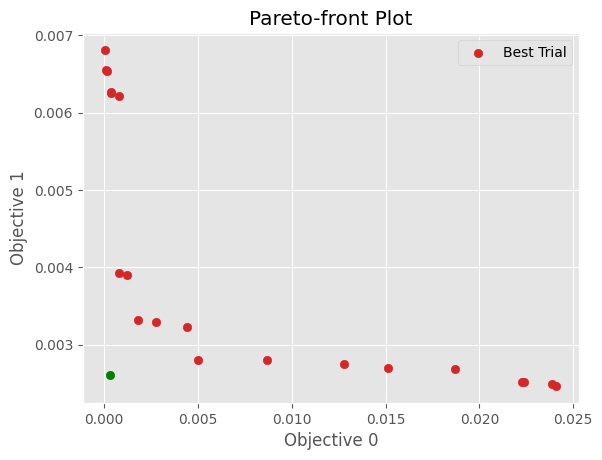

In [99]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)

plt.scatter(centroid_ground, sigma_ground, color='green')
#plt.xscale('log')
#plt.yscale('log')

In [100]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-14.42794135494282
-13.637286174144181
-12.237326782597773
-13.012175311200595
-12.933321668951145
-14.583970173013421
-12.658372952248563
-12.01584218539802
-9.899655378083247
-11.600931393170681
-12.230961329707704
-10.106853225987603
-10.257995335588147
-11.177941049651722
-10.62708128207406
-9.730850498817189
-9.786493372821168
-9.729192929880295
-9.786150427551778
-11.165293384679256


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


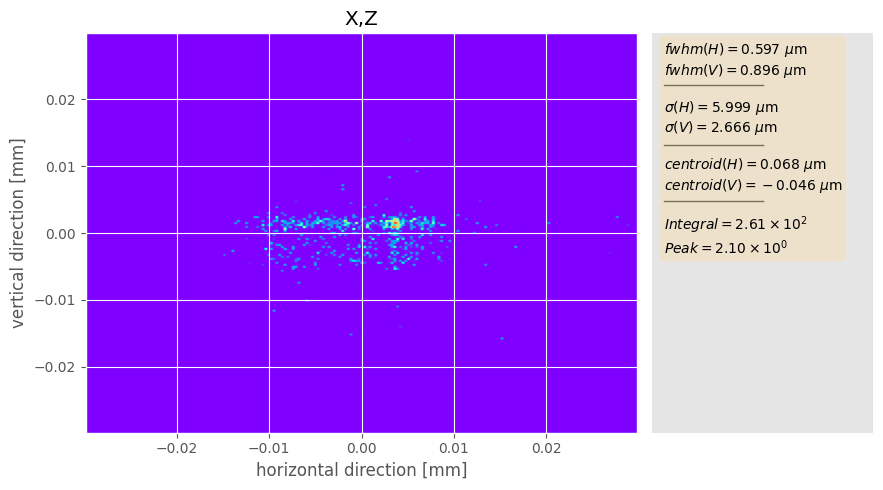

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


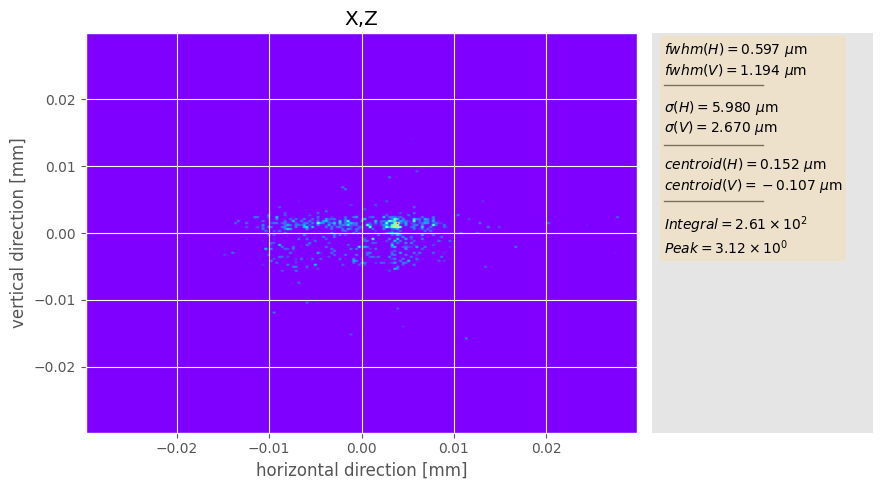

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


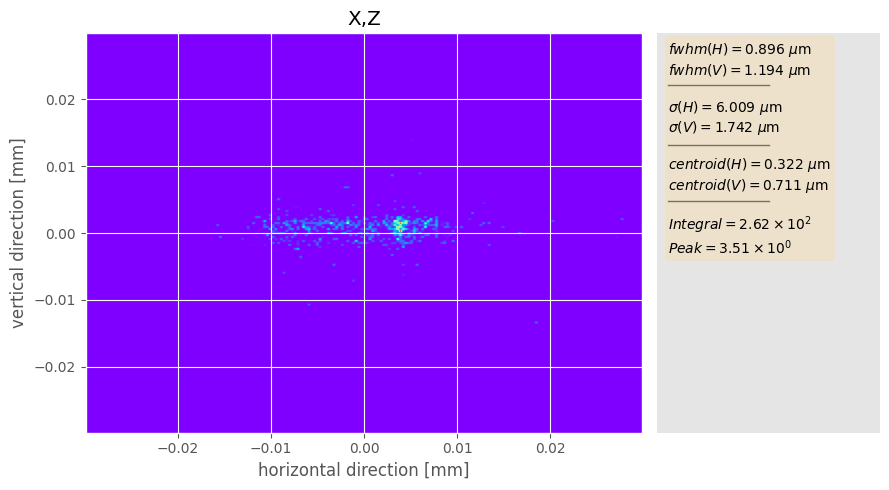

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


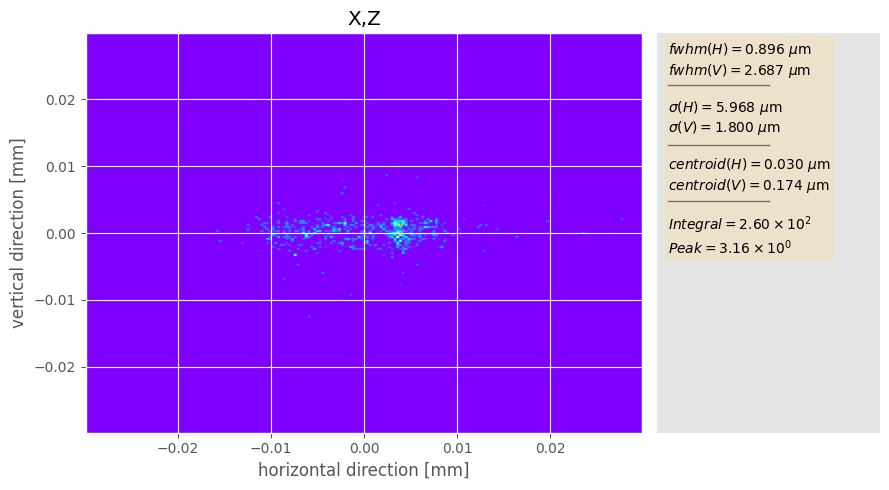

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


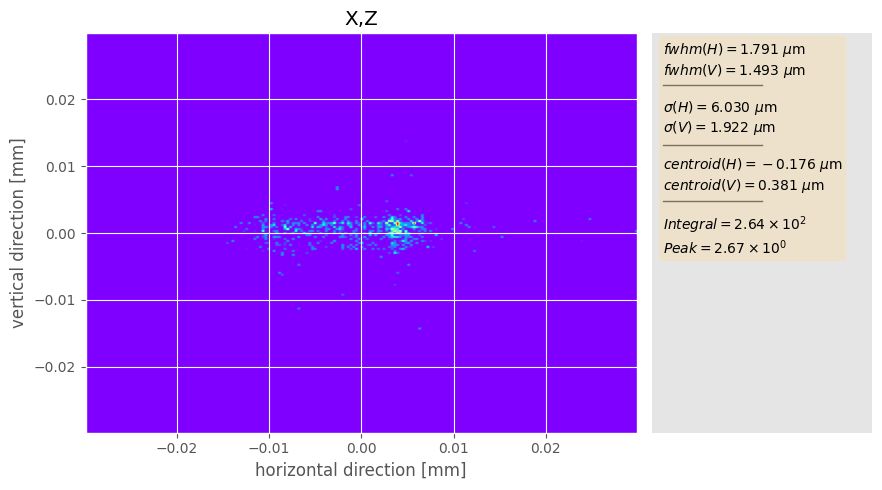

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


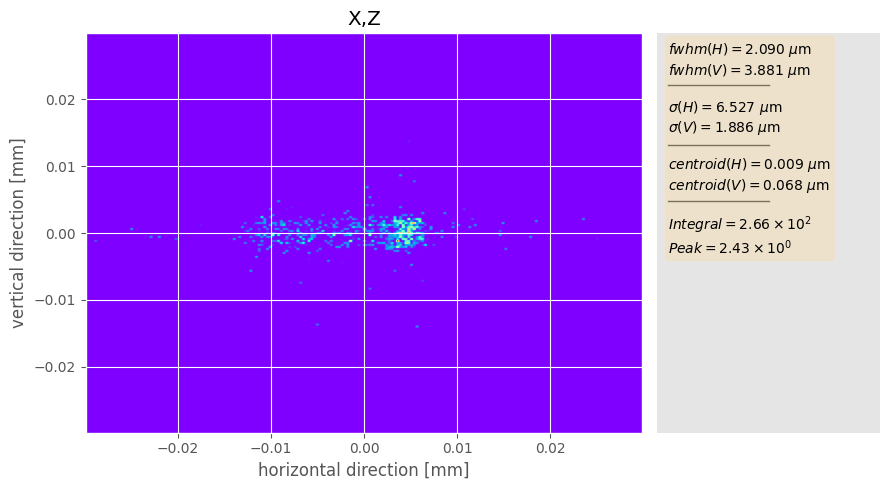

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


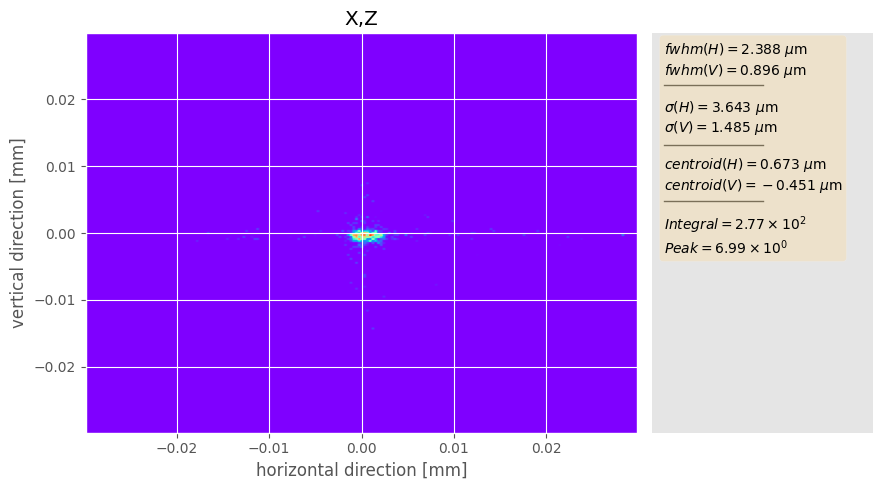

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


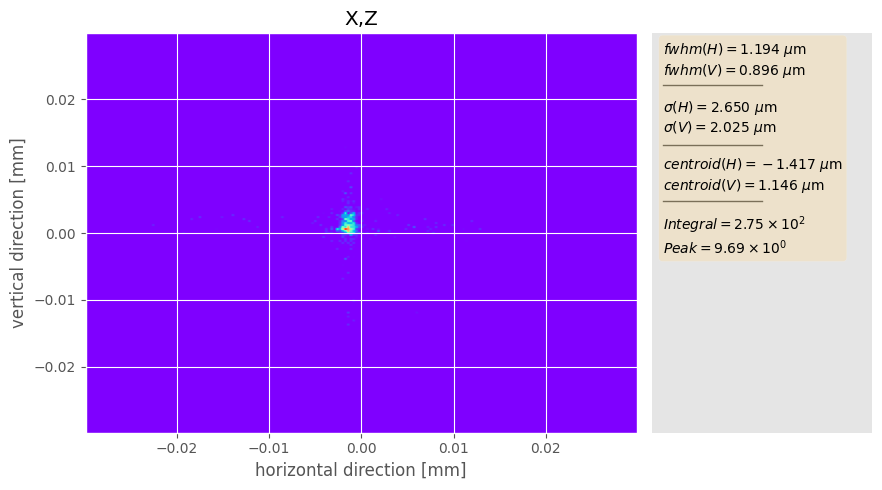

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


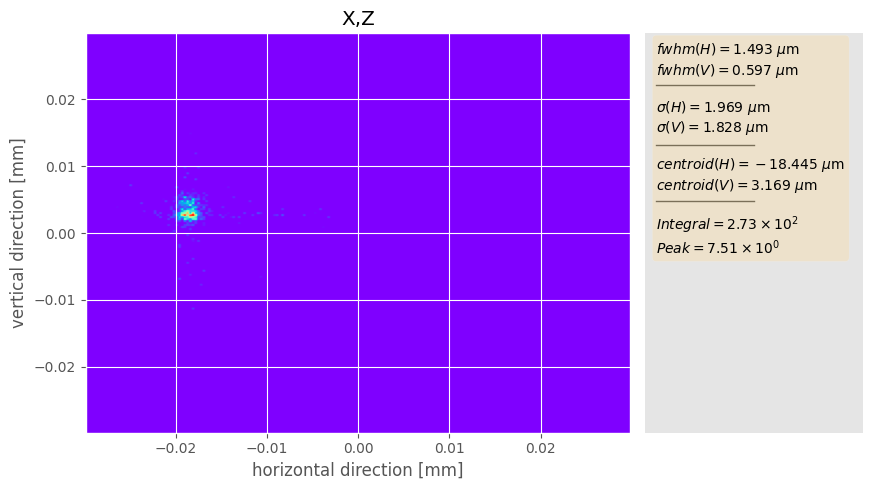

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


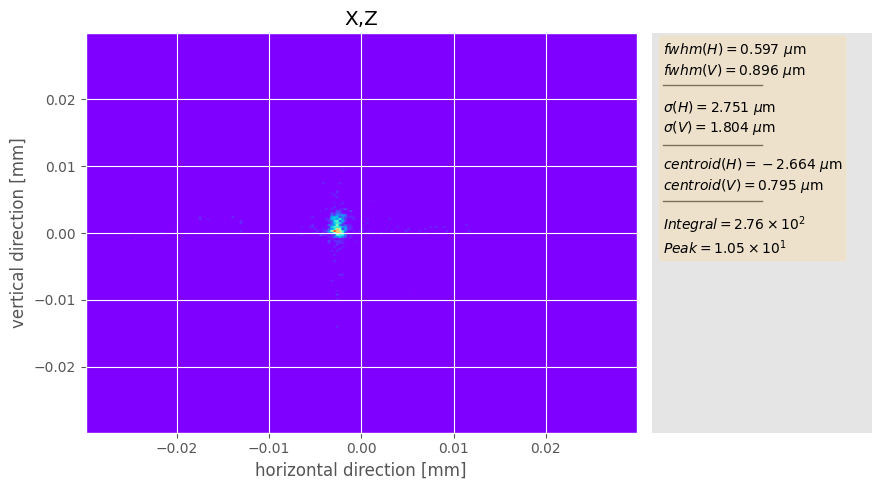

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


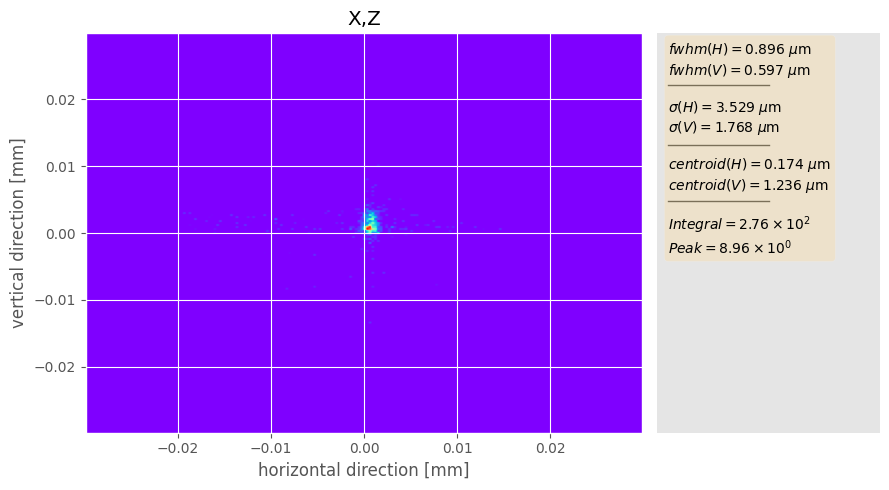

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


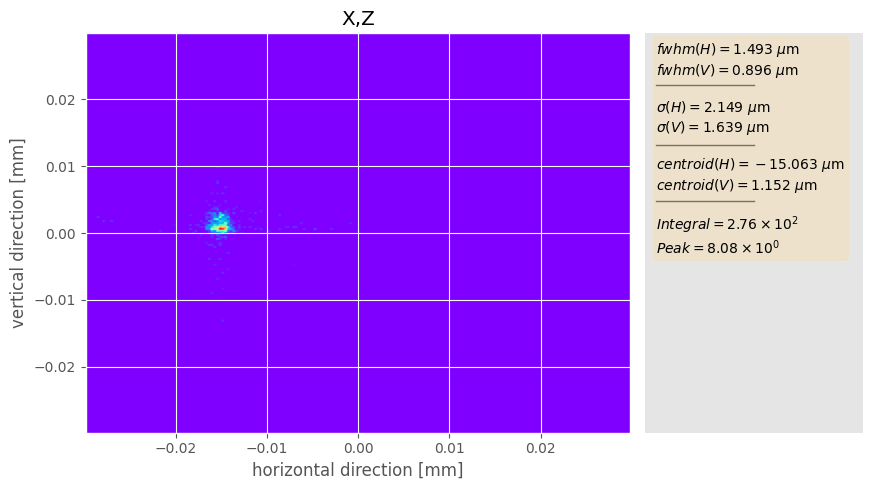

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


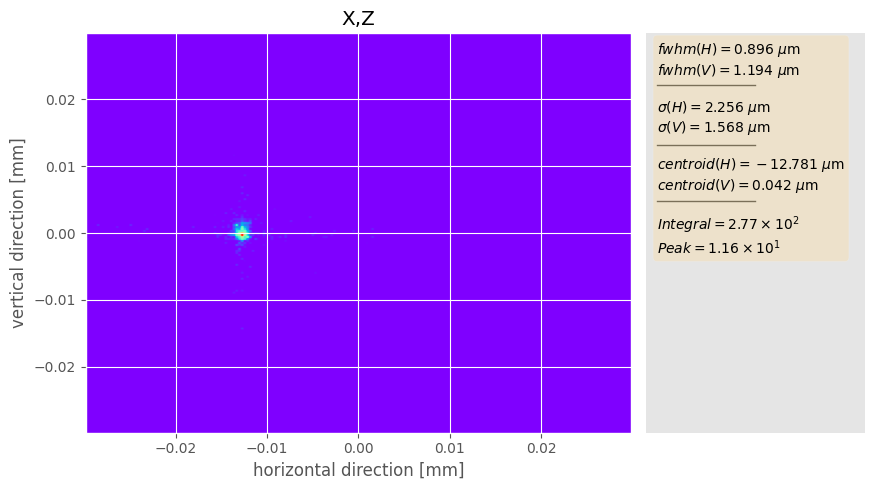

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


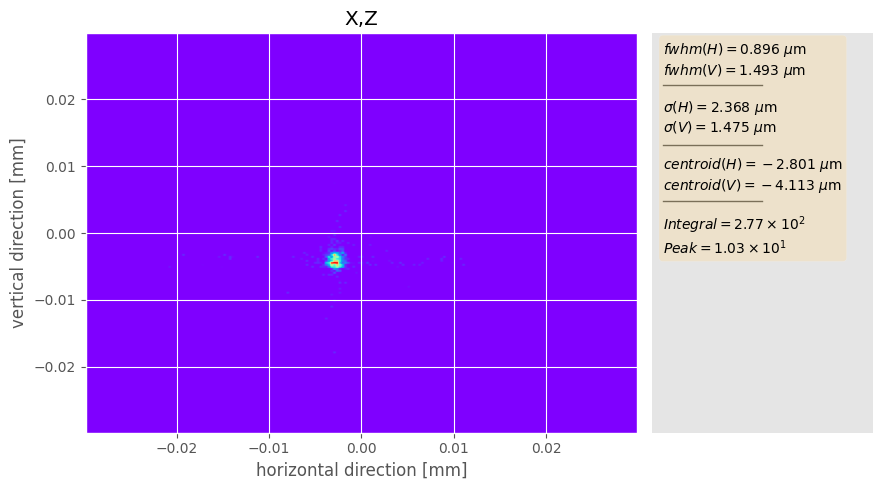

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


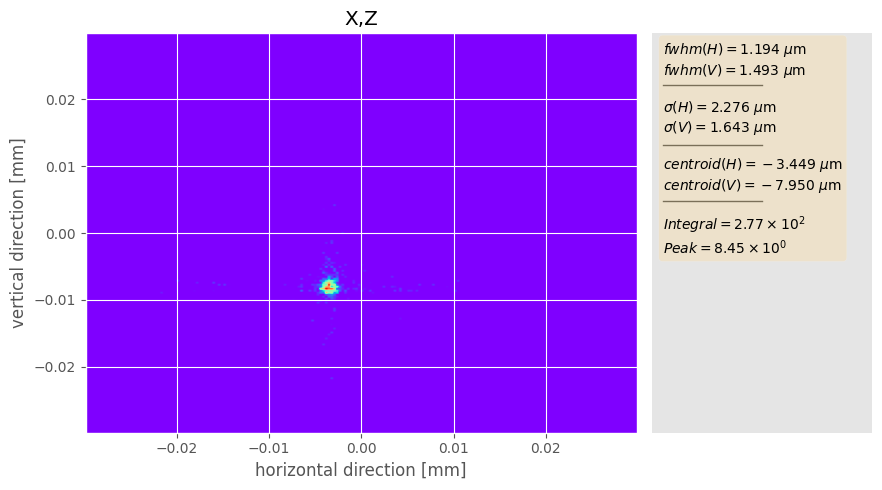

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


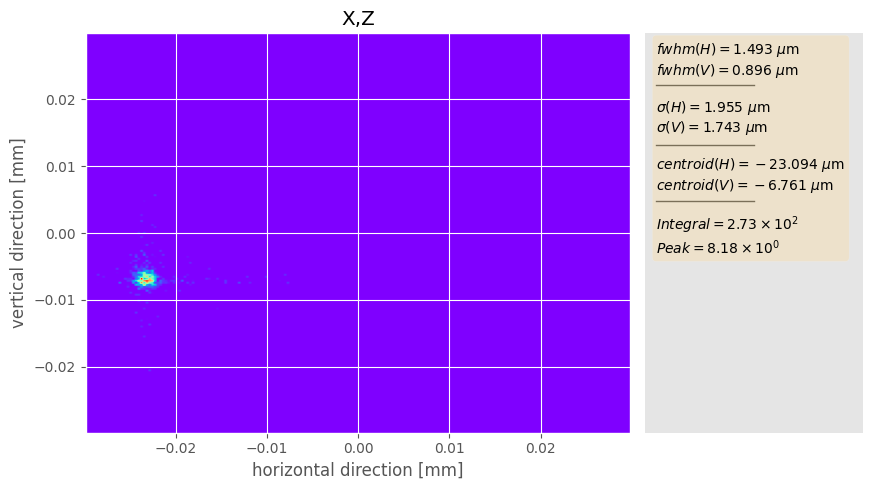

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


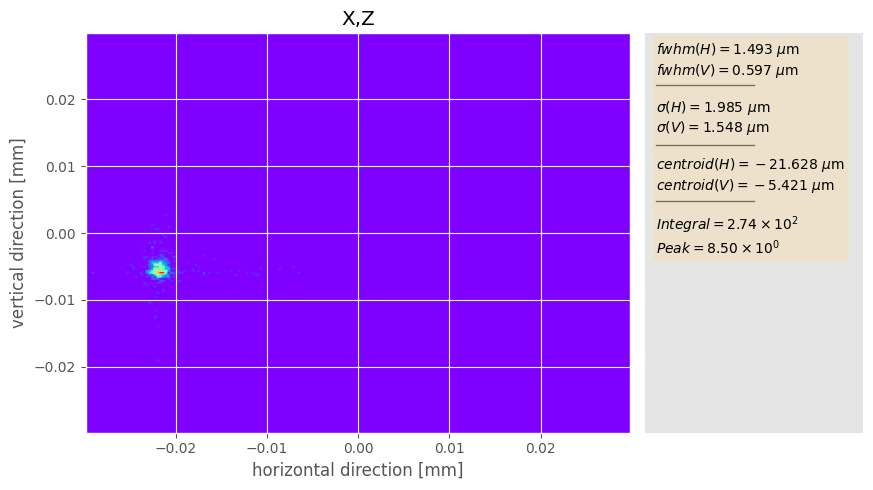

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


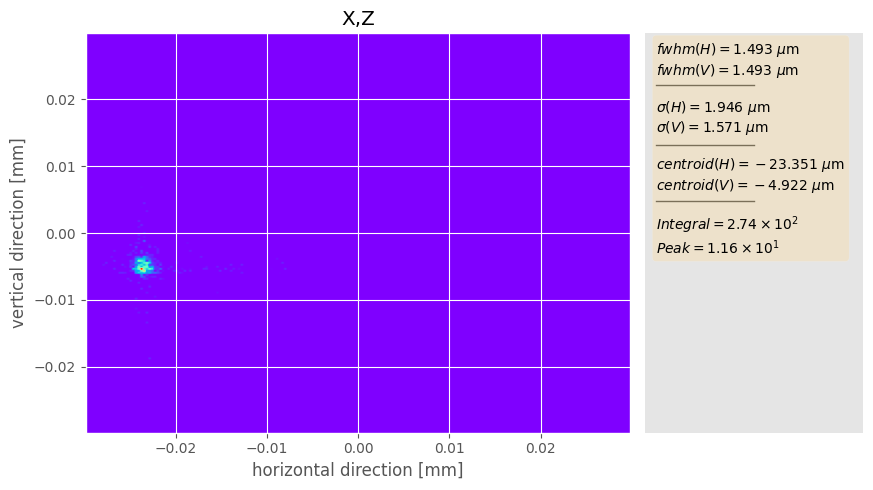

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


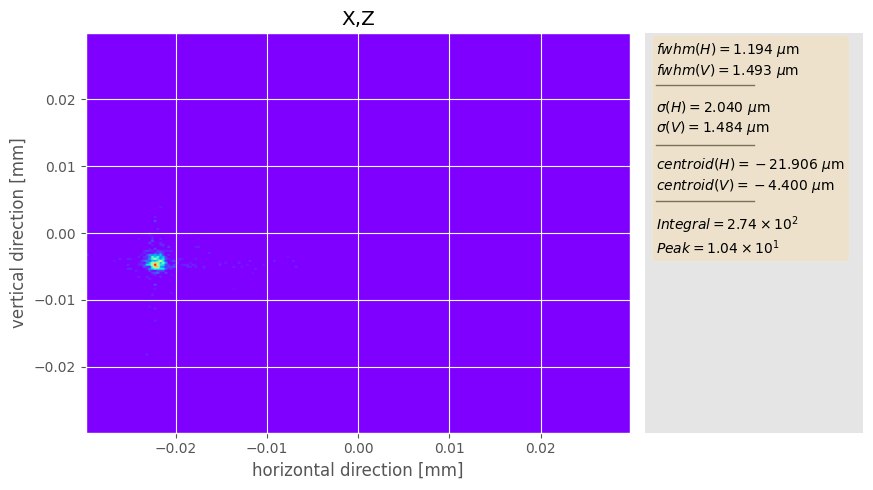

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_84849/Downstream_HKB_bender_profile.dat written to disk.


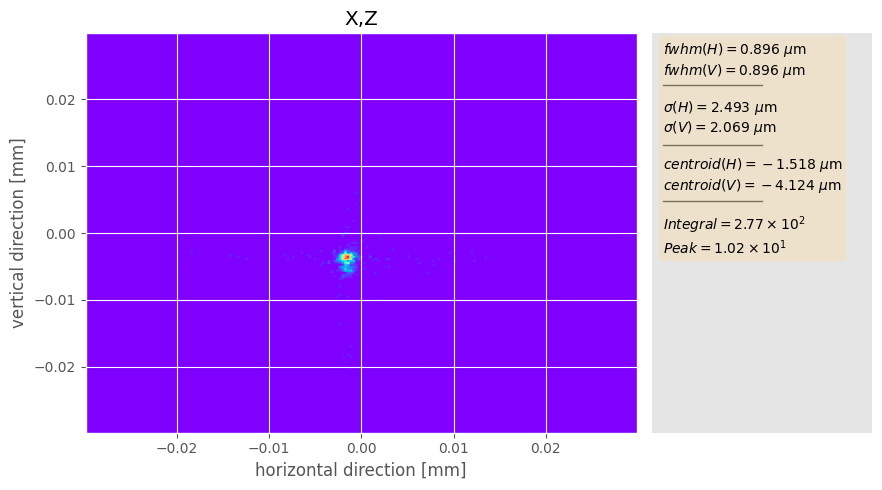

In [101]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)